#### ***Importing Necessary Libraries*** :

In [1]:
#For Model interpretation
!pip install lime
!pip install shap

#install xgboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 6.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=4d2ba322c08b558df0357567b0d56abd7893b4c314bb1d3ff3cd8713c7ae726e
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import numpy as np # mathematical computation
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization
from matplotlib import pyplot
import seaborn as sns # visualization
import warnings 
warnings.filterwarnings('ignore') #ignore warnings
from io import BytesIO
import datetime
import os

#set style
plt.style.use('seaborn')

# Setting font weight,label weight,title weight to bold and setting title size,label size,fontsize.
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.title_fontsize"] = 15

#imports for data preparationa and modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,mean_absolute_error,mean_squared_log_error
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#import for creating tree
from sklearn import tree
from sklearn.tree import plot_tree, export_text
#import pickle Package
import pickle

#imports for model interpretation
import lime
from lime import lime_tabular
import shap

#### ***Importing Bike share rides data*** :

In [3]:

from google.colab import files
uploaded = files.upload()

Saving SeoulBikeData.csv to SeoulBikeData.csv


#### ***Reading CSV file into dataframe*** :


In [4]:
Bikes_df=pd.read_csv(BytesIO(uploaded['SeoulBikeData.csv']),encoding = 'unicode_escape')

#### ***Data Exploration And Data Cleaning*** :

In [5]:
# Check sample 5 rows
Bikes_df.sample(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
3139,10/04/2018,1153,19,19.2,55,5.8,2000,9.9,0.01,0.0,0.0,Spring,No Holiday,Yes
6502,28/08/2018,64,22,22.9,97,1.3,2000,22.3,0.00,0.5,0.0,Summer,No Holiday,Yes
4034,18/05/2018,48,2,18.8,98,1.5,237,18.4,0.00,0.5,0.0,Spring,No Holiday,Yes
8013,30/10/2018,1147,21,7.6,55,2.0,2000,-0.8,0.00,0.0,0.0,Autumn,No Holiday,Yes
6622,02/09/2018,1511,22,25.7,64,1.1,2000,18.3,0.00,0.0,0.0,Autumn,No Holiday,Yes


In [6]:
# overview of dimensions  and datatypes of the dataset 
print(f'The shape of dataset is {(Bikes_df.shape)} \n Total Rows are : {(Bikes_df.shape)[0]}\n Total Columns are : {(Bikes_df.shape)[1]}')
print('\n')
Bikes_df.info()

The shape of dataset is (8760, 14) 
 Total Rows are : 8760
 Total Columns are : 14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday            

In [7]:
#Dealing with invalid data types
Bikes_df['Date']=Bikes_df['Date'].astype('datetime64[ns]')
Bikes_df['Seasons']=Bikes_df['Seasons'].astype('category')
Bikes_df['Holiday']=Bikes_df['Holiday'].astype('category')
Bikes_df['Hour']=Bikes_df['Hour'].astype('category')
Bikes_df['Functioning Day']=Bikes_df['Functioning Day'].astype('category')
# Renaming columns for better analysis
Bikes_df.rename(columns={'Rented Bike Count':'Rented_Bike_Count','Temperature(°C)':'Temperature','Humidity(%)':'Humidity','Wind speed (m/s)':'Wind_speed',
                       'Visibility (10m)':'Visibility','Dew point temperature(°C)':'Dew_point_temperature', 'Solar Radiation (MJ/m2)':'Solar_Radiation',
                        'Rainfall(mm)':'Rainfall','Snowfall (cm)':'Snowfall','Functioning Day':'Functioning_Day'},inplace=True)

#Extracting Month and Day of the week from Date
Bikes_df['Month']=Bikes_df['Date'].dt.month_name().astype('category')
Bikes_df['Day']=Bikes_df['Date'].dt.day_name().astype('category')
Bikes_df["year"] = Bikes_df['Date'].map(lambda x: x.year).astype("category")

#Adding Weekend column from day as 1 for weekedn and 0 for weekday
Bikes_df['Weekend']=Bikes_df['Day'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
Bikes_df['Weekend']=Bikes_df['Weekend'].astype('category')
# drop the Date column
Bikes_df.drop(columns=['Date'],inplace=True)



In [8]:
# Checking for missing values
print(f'Null values :\n{Bikes_df.isnull().sum()}')
print('\n')
#Checking for duplicate values
print(f'Duplicate values : {sum(Bikes_df.duplicated())}')

Null values :
Rented_Bike_Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind_speed               0
Visibility               0
Dew_point_temperature    0
Solar_Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning_Day          0
Month                    0
Day                      0
year                     0
Weekend                  0
dtype: int64


Duplicate values : 0


In [9]:
#Summary statistics of numerical columns
Bikes_df.describe().style.background_gradient()

,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


#### ***Exploratory Data Analysis :***

In [10]:
#Overview of data
Bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Rented_Bike_Count      8760 non-null   int64   
 1   Hour                   8760 non-null   category
 2   Temperature            8760 non-null   float64 
 3   Humidity               8760 non-null   int64   
 4   Wind_speed             8760 non-null   float64 
 5   Visibility             8760 non-null   int64   
 6   Dew_point_temperature  8760 non-null   float64 
 7   Solar_Radiation        8760 non-null   float64 
 8   Rainfall               8760 non-null   float64 
 9   Snowfall               8760 non-null   float64 
 10  Seasons                8760 non-null   category
 11  Holiday                8760 non-null   category
 12  Functioning_Day        8760 non-null   category
 13  Month                  8760 non-null   category
 14  Day                    8760 non-null   c

***When are the most rides happening ?*** 📅

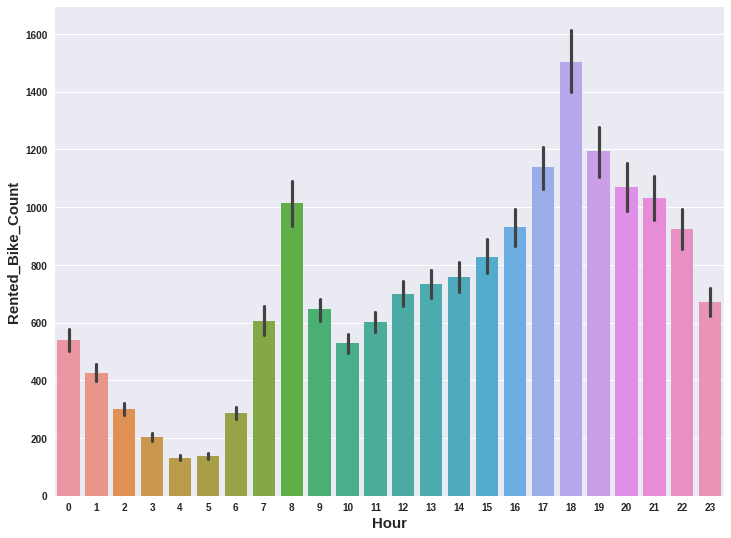

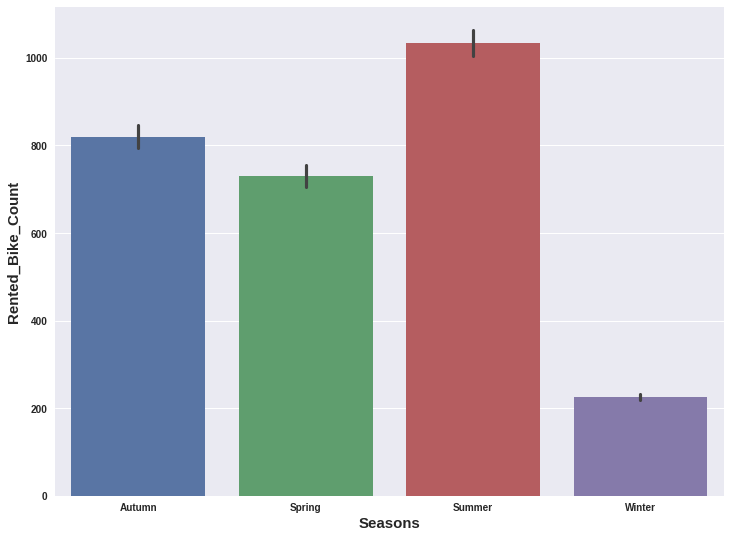

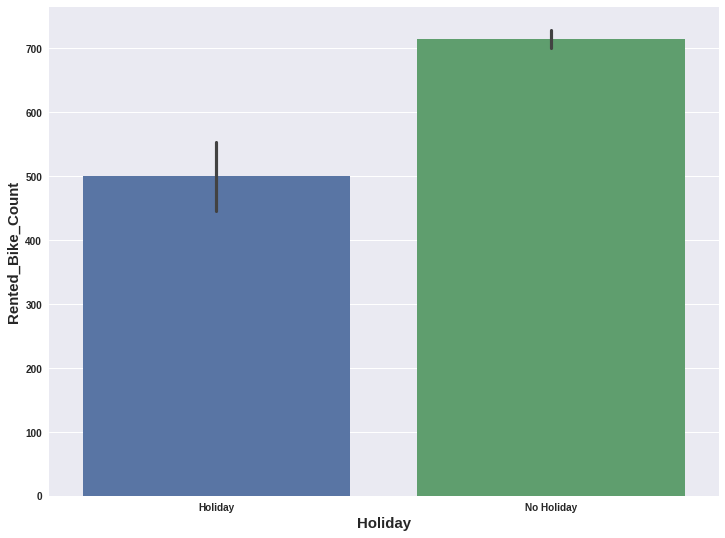

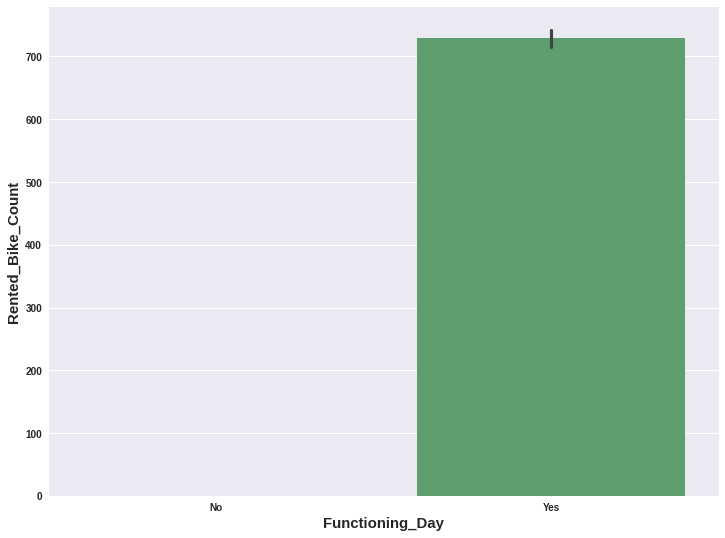

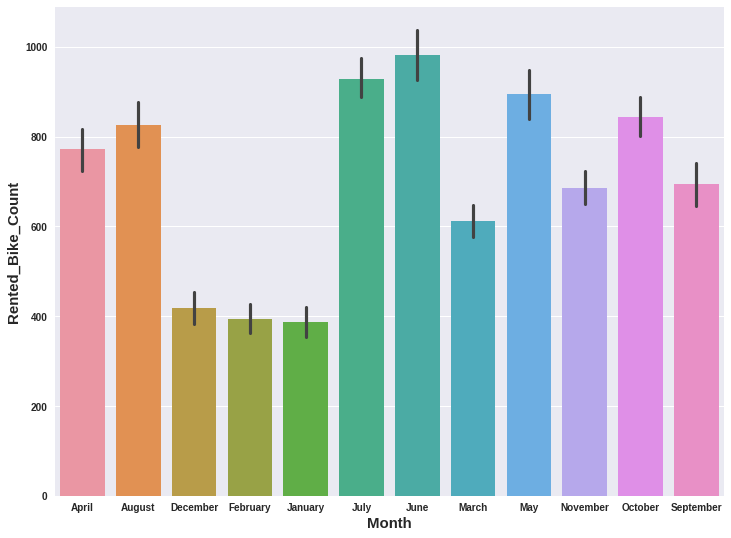

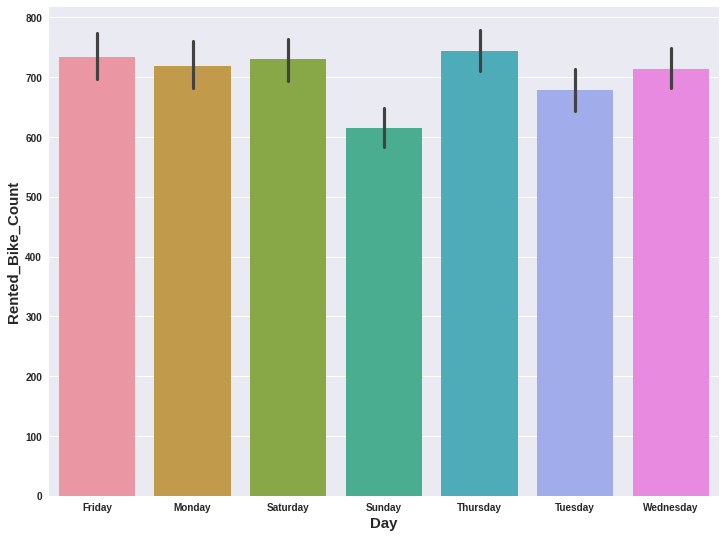

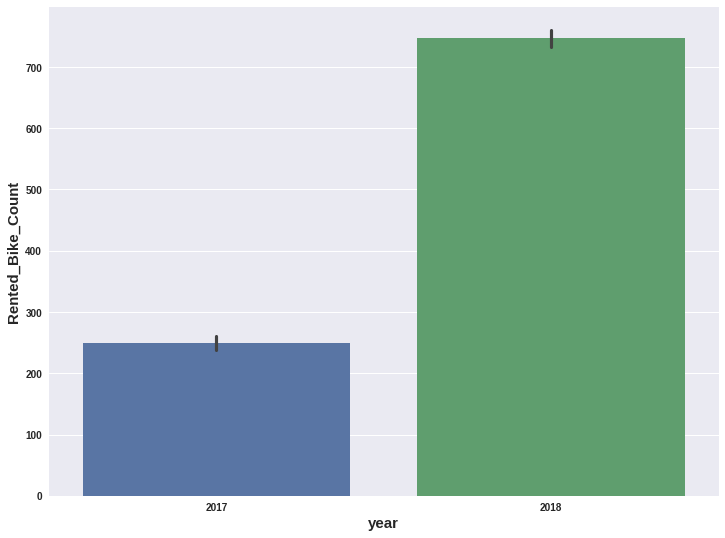

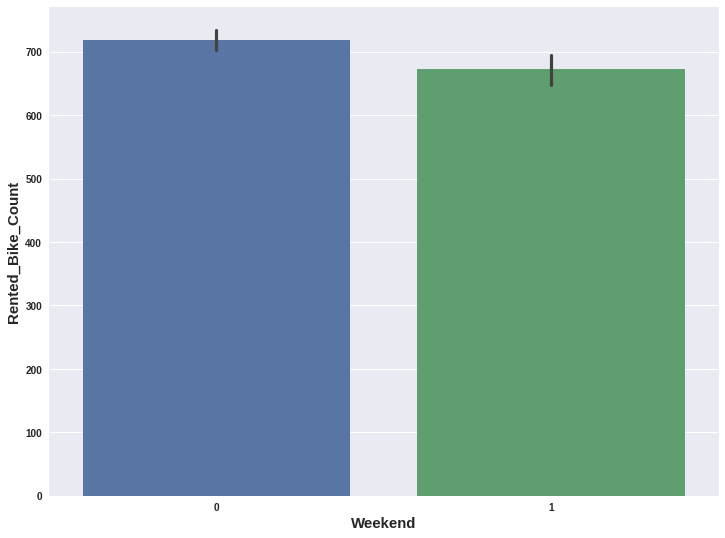

In [11]:
numeric_features= Bikes_df.select_dtypes(exclude=['category','datetime64'])
categorical_features=Bikes_df.select_dtypes(include='category')
# Plot barchart plot for each categorical columns with respect to target variable to get insights
for col in categorical_features:
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca()
    sns.barplot(x=Bikes_df[col],y=Bikes_df['Rented_Bike_Count'])



>***Observations:***

*  ***Time of day:*** It is evident that the peaks are observed in mornings at 8AM & 9AM and evenings at 4PM, 5PM & 6PM implicating that majority of the trips are taken before and after the usual office hours. Moreover, the trips taken in between the usual office hours i.e. 10AM — 3PM are constant. Additionaly, the trips have declined substantially after 6PM.

*   ***Day of week:*** As majority of the trips were taken before and after the usual office hours, it is no surprise that majority of the trips have taken place at weekdays (Mon-Fri) as compared to weekends (Sat-Sun)

*   ***Season :*** We observe that summer has the highest rentals followed by spring and then fall, which gives us reason to believe that the bike riders prefer warm to pleasant climates than colder climates.









##### ***What is the distribution of rides on different kinds of days wrt Hours?***

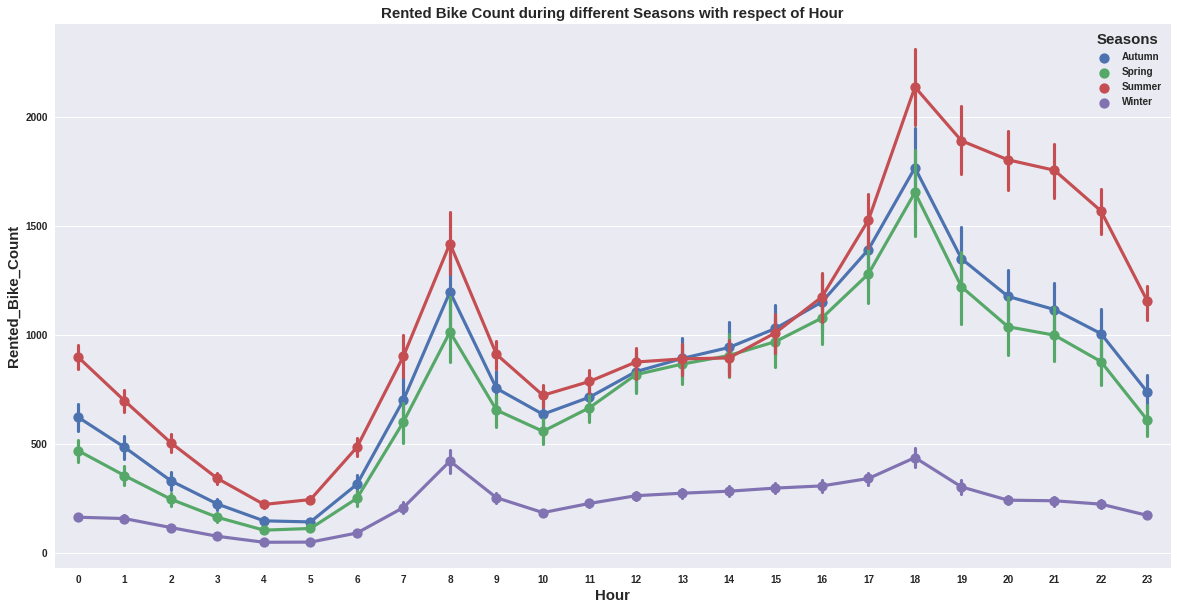

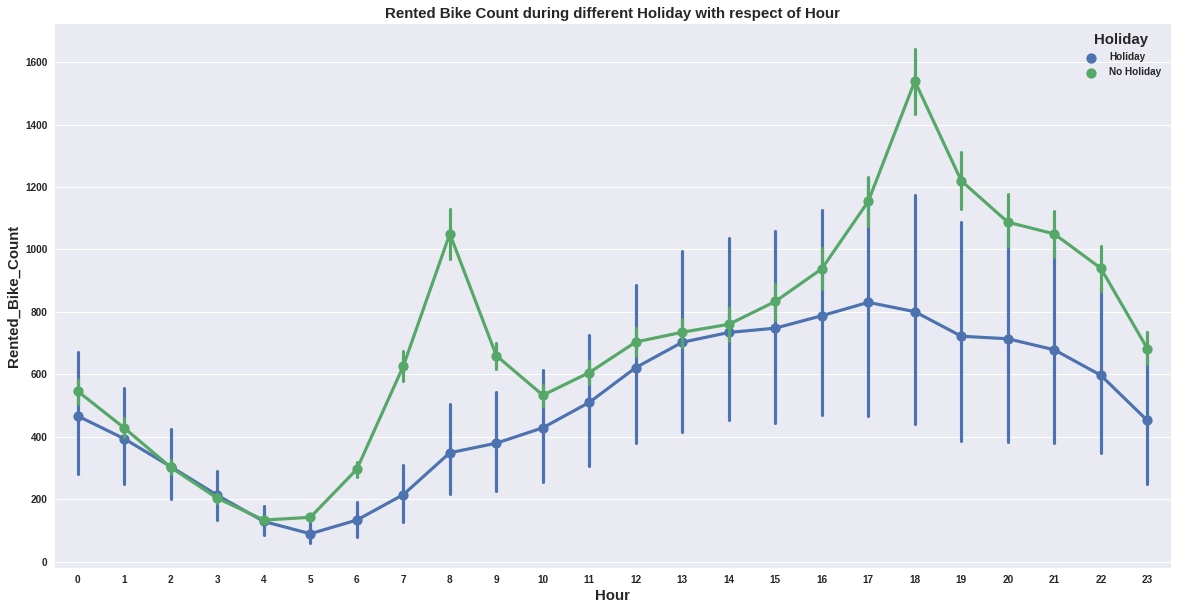

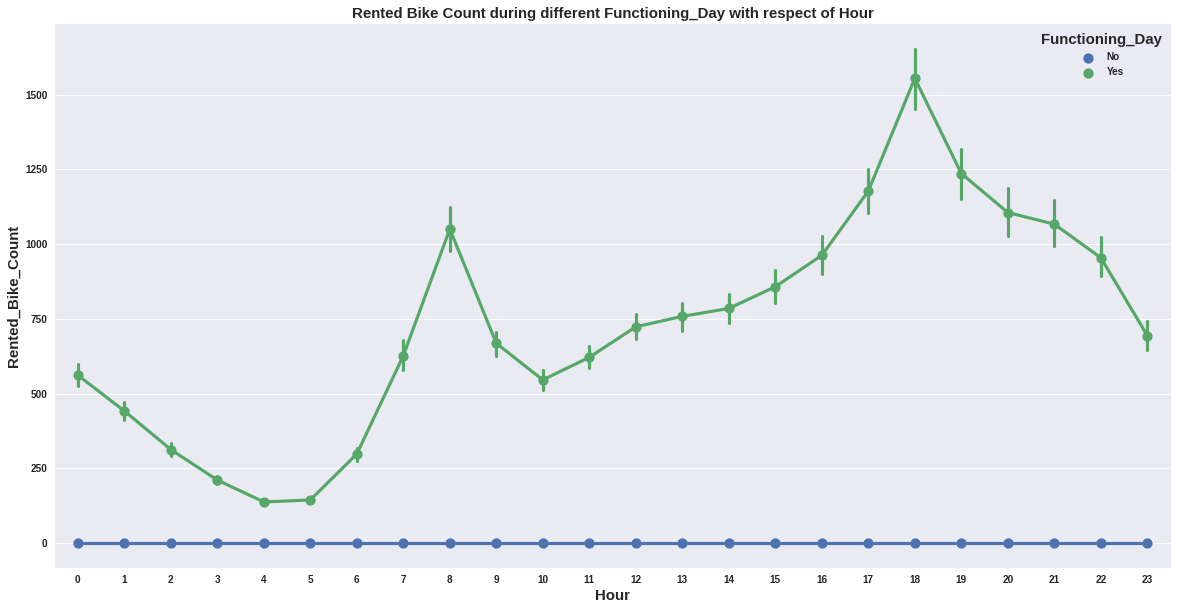

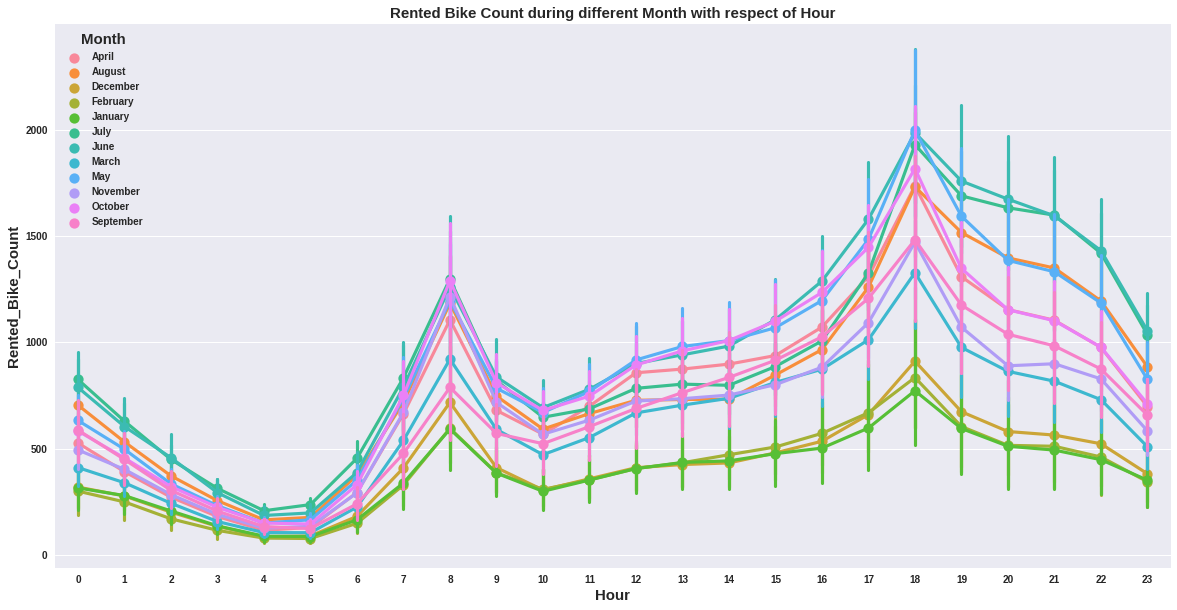

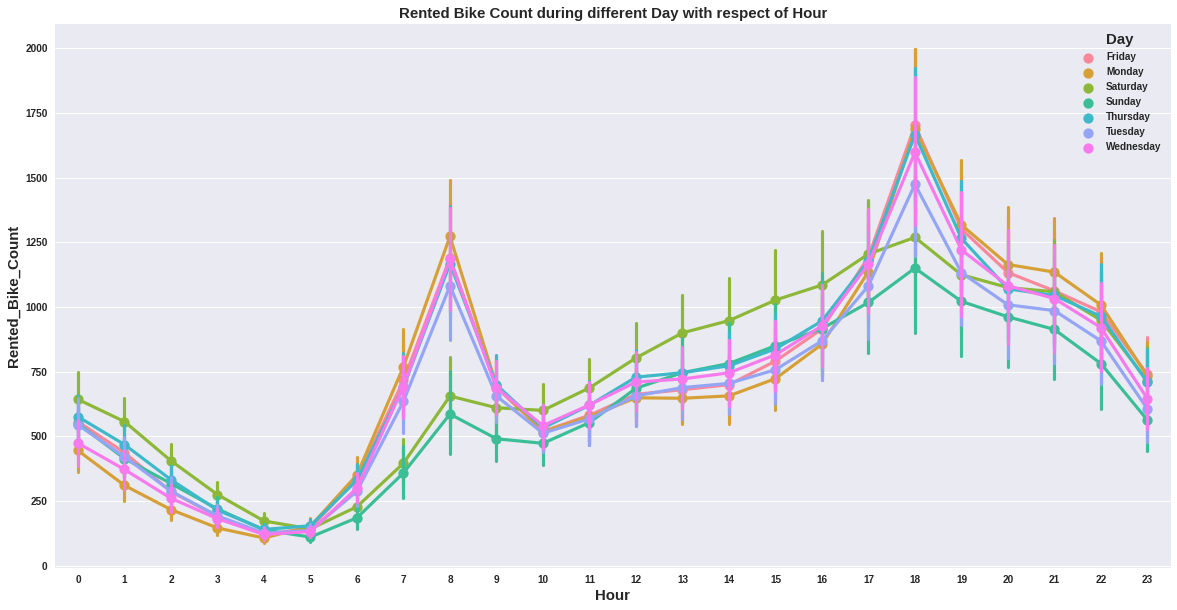

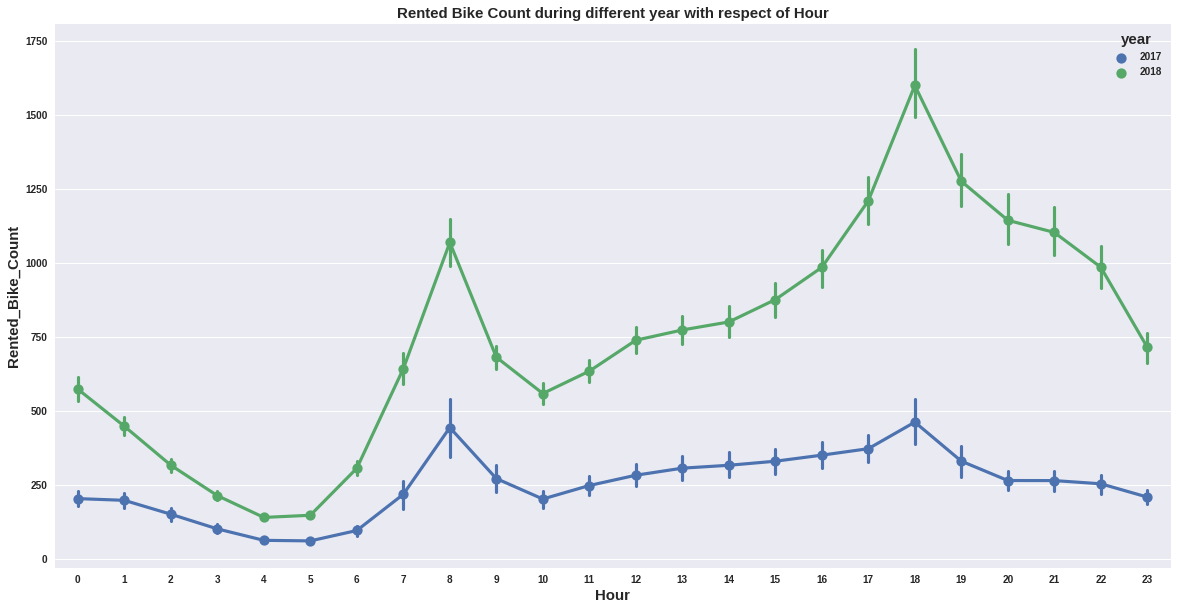

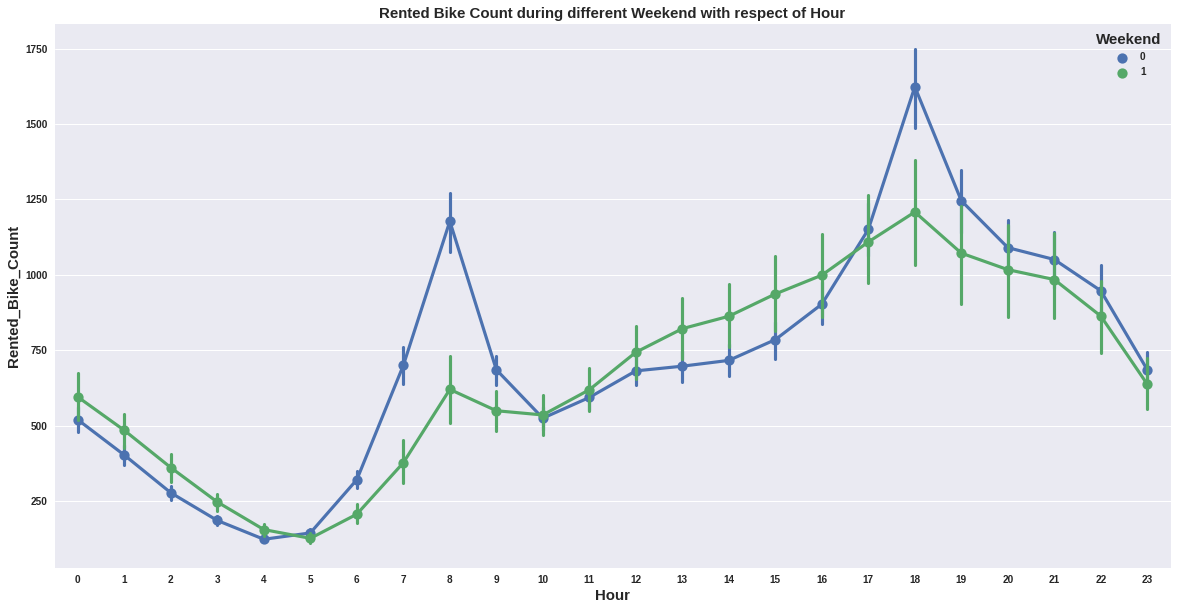

In [12]:
for i in categorical_features:
  if i == 'Hour':
    pass
  else:
    plt.figure(figsize=(20,10))
    sns.pointplot(x=Bikes_df["Hour"],y=Bikes_df['Rented_Bike_Count'],hue=Bikes_df[i])
    plt.title(f"Rented Bike Count during different {i} with respect of Hour")
  plt.show()



> ***Observations :***


* We can observe that the pattern of weekdays and weekends as well as Holidays is different, in the weekend and on holiday the demand becomes high in the afternoon. While the demand for office timings is high during weekdays and no holidays.

* In the month column, We can clearly see that the demand is low in December January & Febuary,  as it is cold in these months and we have already seen in season column that demand is less in winters.

*  Comparitively the demand was high in 2018 than in 2017, which can support the fact that bike share demand is increasing over the years.






#### ***What is the distribution and correlation among variables ?***



********************************************************************** Rented_Bike_Count **********************************************************************




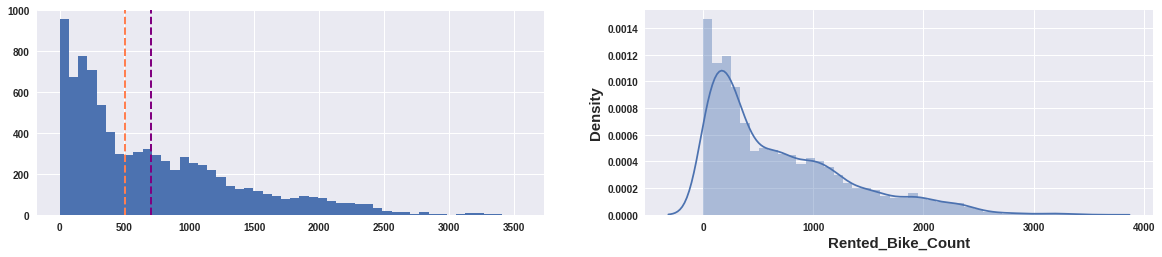



********************************************************************** Temperature **********************************************************************




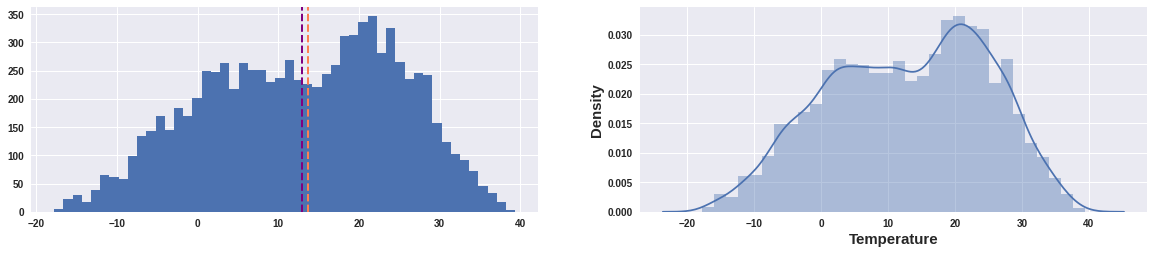



********************************************************************** Humidity **********************************************************************




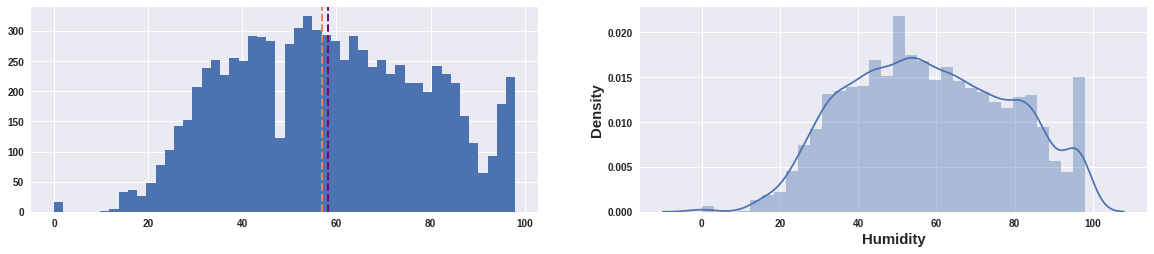



********************************************************************** Wind_speed **********************************************************************




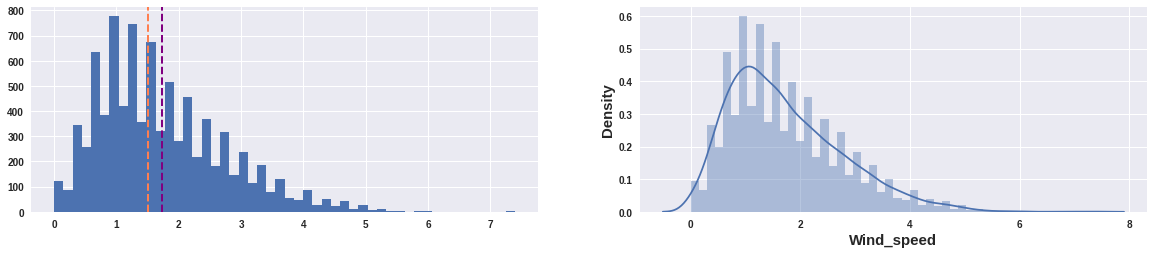



********************************************************************** Visibility **********************************************************************




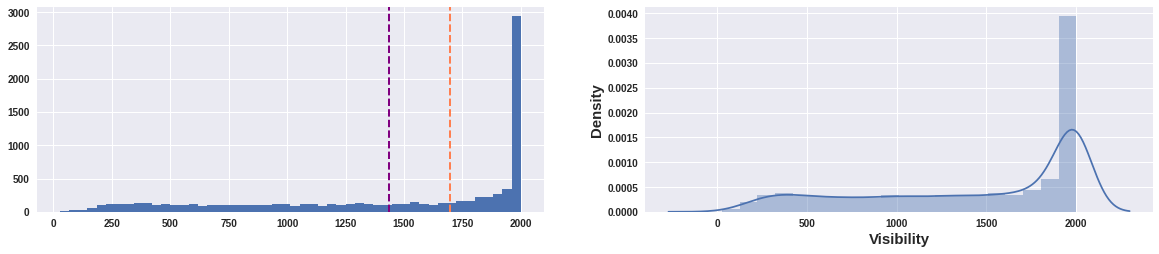



********************************************************************** Dew_point_temperature **********************************************************************




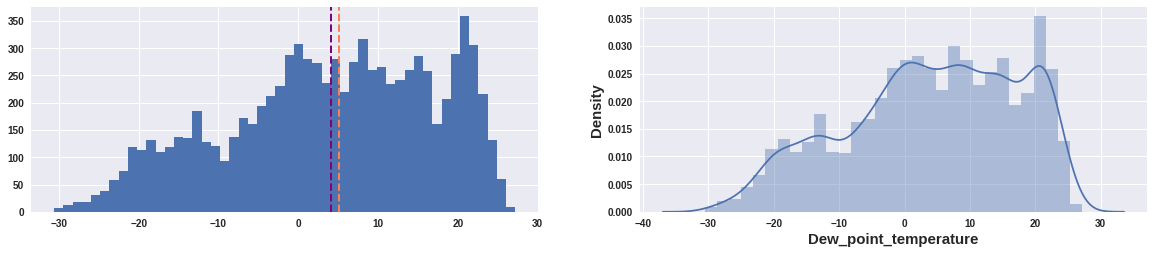



********************************************************************** Solar_Radiation **********************************************************************




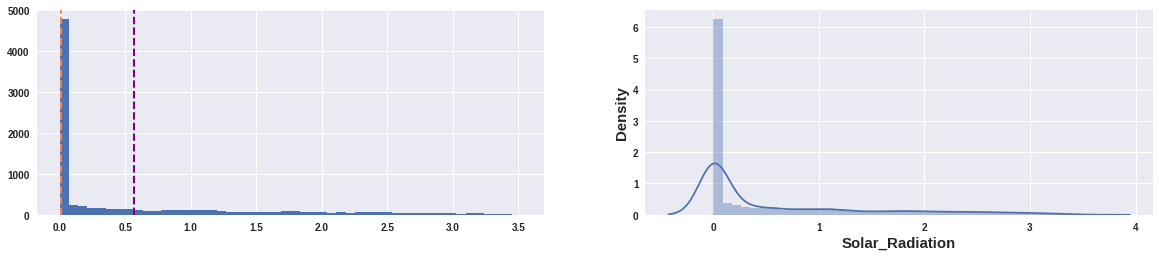



********************************************************************** Rainfall **********************************************************************




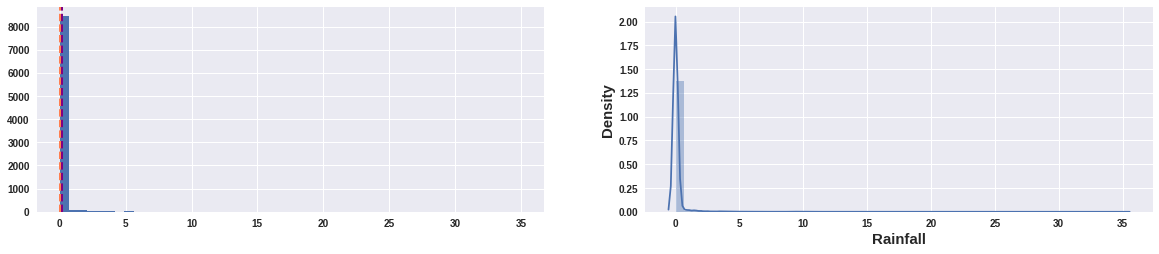



********************************************************************** Snowfall **********************************************************************




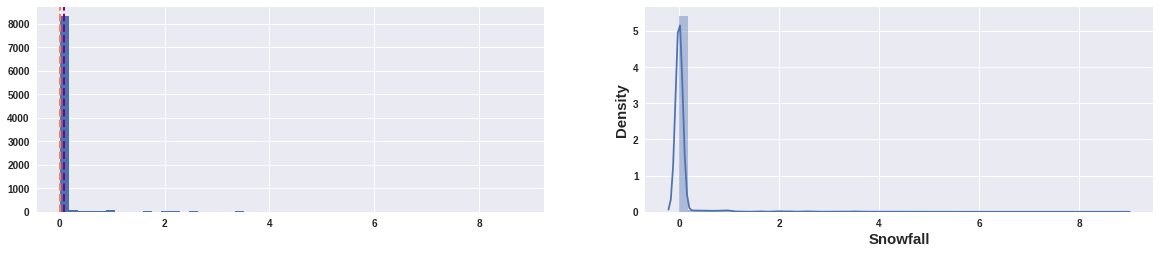

In [13]:
#plotting histogram with mean and median, and distplot of all the numeric features of the dataset
n=1
for i in numeric_features.columns:
  plt.figure(figsize=(20,40))
  plt.subplot(9,2,n)
  n+=1
  print('\n')
  print('*'*70,i,'*'*70)
  print('\n')
  # fig=plt.figure()
  # ax=fig.gca()
  feature=Bikes_df[i]
  feature.hist(bins=50,)
  plt.axvline(feature.mean(), color='purple', linestyle='dashed', linewidth=2)
  plt.axvline(feature.median(), color='coral', linestyle='dashed', linewidth=2) 
  plt.subplot(9,2,n)
  n+= 1
  sns.distplot(Bikes_df[i])
  # plt.tight_layout()
  plt.show()

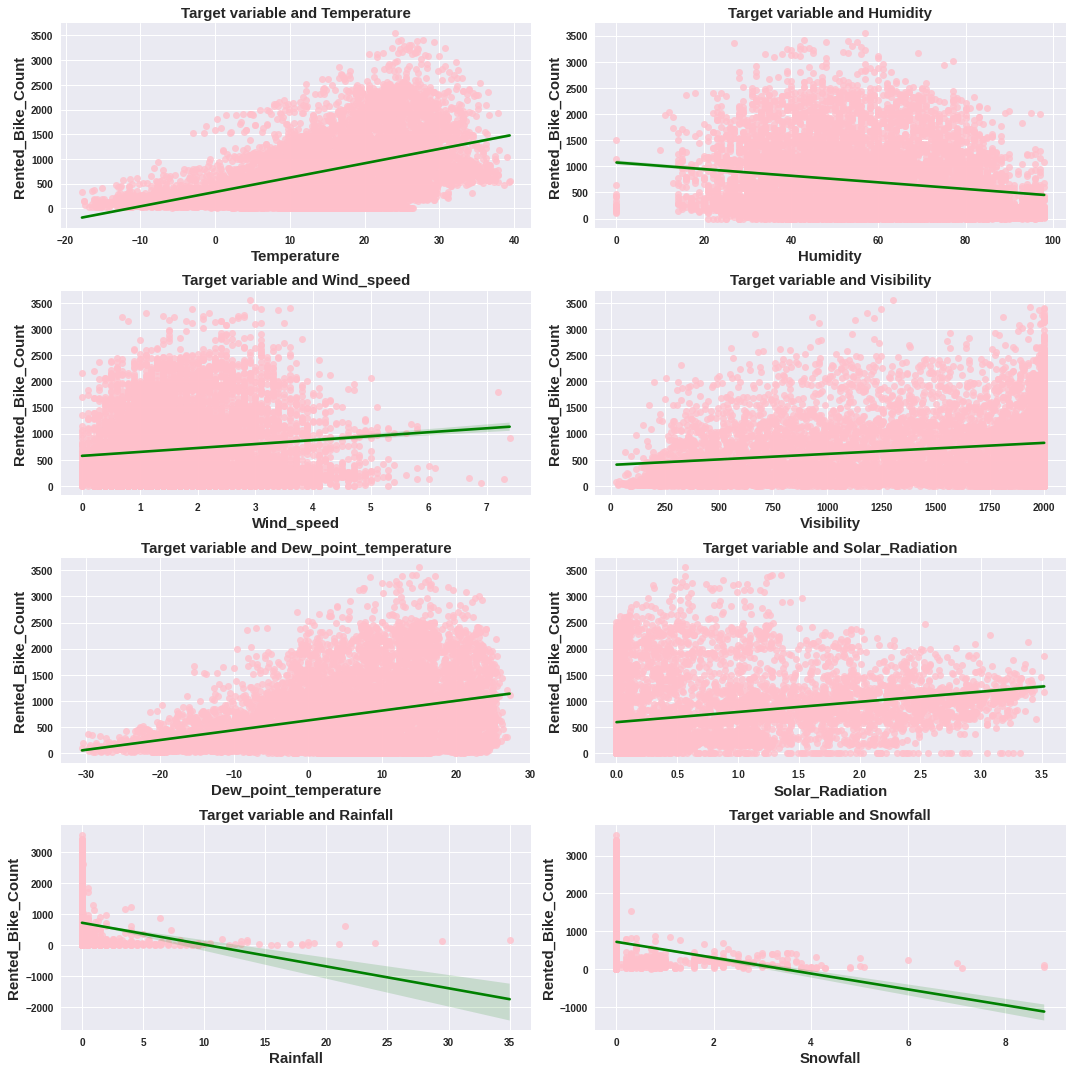

In [14]:
# Regression plot to know relation of target variable with our independent variable
n=1
plt.figure(figsize=(15,15))
for i in numeric_features.columns:
  if i == 'Rented_Bike_Count':
    pass
  else:
    plt.subplot(4,2,n)
    n+=1
    sns.regplot(Bikes_df[i], Bikes_df['Rented_Bike_Count'],scatter_kws={"color": "pink"}, line_kws={"color": "green"})
    plt.title(f'Target variable and {i}')
    plt.tight_layout()

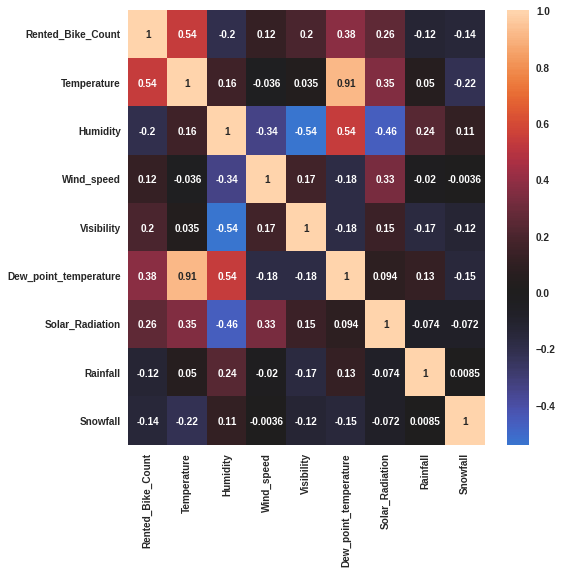

In [15]:
#correlation of all the numerical features with the heat map, so that we will also get to know the multicolinearity
plt.figure(figsize=(8,8))
sns.heatmap(Bikes_df.select_dtypes(include=['float','int']).corr(),annot=True,center = 0)
plt.show()

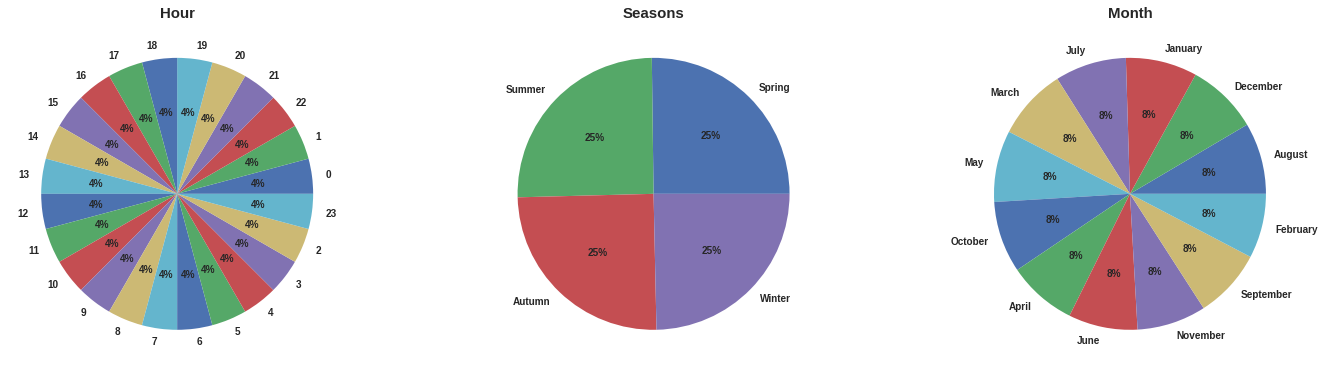

In [16]:
#Checking for Data imbalance by creating pieplot
n=1
plt.figure(figsize=(20,15))
columns=['Hour','Seasons','Month']
for i in columns:
  plt.subplot(3,3,n)
  n=n+1
  plt.pie(Bikes_df[i].value_counts(),labels = Bikes_df[i].value_counts().keys().tolist(),autopct='%.0f%%')
  plt.title(i)
  plt.tight_layout()



>***Observations :***


*   From the distplots we could see that some of the variables are either right or left skewed and for those variables, even the mean and median are skewed as seen in the histograms.

*  Regression plots show that the few variables are positively correlated and few are nagtively correlated with our target variable.

* From Heat map, we could see that there is multicollinearity between few variables like Temperature and Dew point temperature.

* From the pie plots , we could see that the data is uniformly distributed across all seasons, months and hours. Hence, there is no data imbalance.





#### ***Preparing Data for Modeling*** :

In [17]:
# Make copy of dataset
df=Bikes_df.copy()
df

,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Month,Day,year,Weekend
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,January,Thursday,2017,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes,November,Friday,2018,0


***Multicollinearity*** can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.It can be detected via various methods. 
In this project, we used the most common approach ***VIF (Variable Inflation Factors).***

VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.If VIF >5, then variables are highly collinear and the parameter estimates will have large standard errors due to this.








In [18]:
#Detecting Multicollinearity using VIF(Variable Inflation Factors)
def Calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
#excluding target variable
Calculate_vif(df[[i for i in df.describe().columns if i not in ['Rented_Bike_Count']]])

,variables,VIF
0,Temperature,29.075866
1,Humidity,5.069743
2,Wind_speed,4.517664
3,Visibility,9.051931
4,Dew_point_temperature,15.201989
5,Solar_Radiation,2.821604
6,Rainfall,1.079919
7,Snowfall,1.118903


In [19]:
# As per above vif calculation dropping  dew_point_temperature columns.
df.drop(['Dew_point_temperature','Day'],inplace=True,axis=1)
Calculate_vif(df[[i for i in df.describe().columns if i not in ['Rented_Bike_Count']]])

,variables,VIF
0,Temperature,3.166007
1,Humidity,4.758651
2,Wind_speed,4.079926
3,Visibility,4.409448
4,Solar_Radiation,2.246238
5,Rainfall,1.078501
6,Snowfall,1.118901


In [20]:
# Creating dummy variables
df=pd.get_dummies(df,drop_first=True,sparse=True)
# checking modified data
df.head(5)

,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Solar_Radiation,Rainfall,Snowfall,Hour_1,Hour_2,...,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,year_2018,Weekend_1
0,254,-5.2,37,2.2,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,204,-5.5,38,0.8,2000,0.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,173,-6.0,39,1.0,2000,0.0,0.0,0.0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,107,-6.2,40,0.9,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,78,-6.0,36,2.3,2000,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0


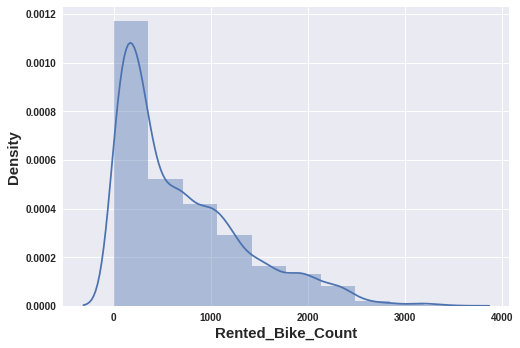

In [30]:
# Plot the distribution of the target variable to check for skewness
fig = plt.figure()
sns.distplot((df['Rented_Bike_Count']), bins = 10)


As the target variable is right skewed, we can normalize it by applying  either squareroot or log transformation.

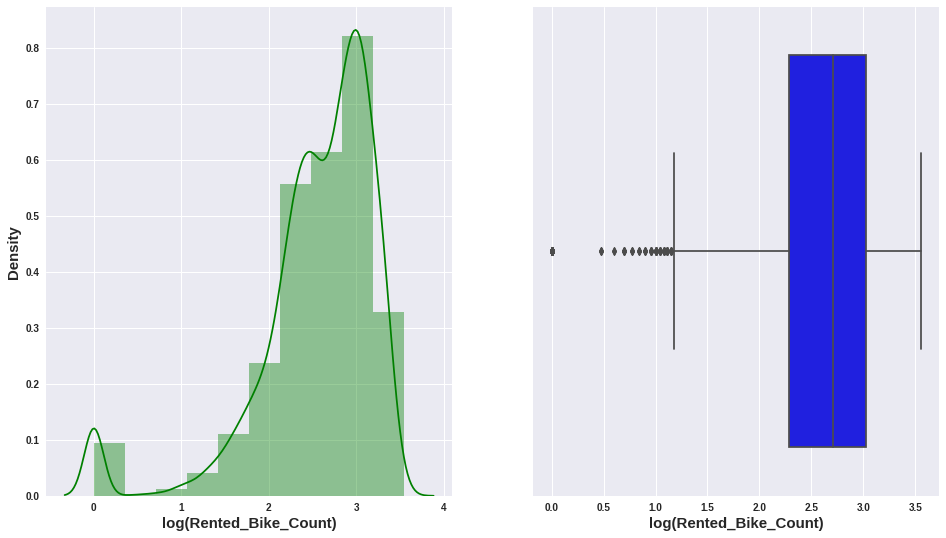

<Figure size 576x396 with 0 Axes>

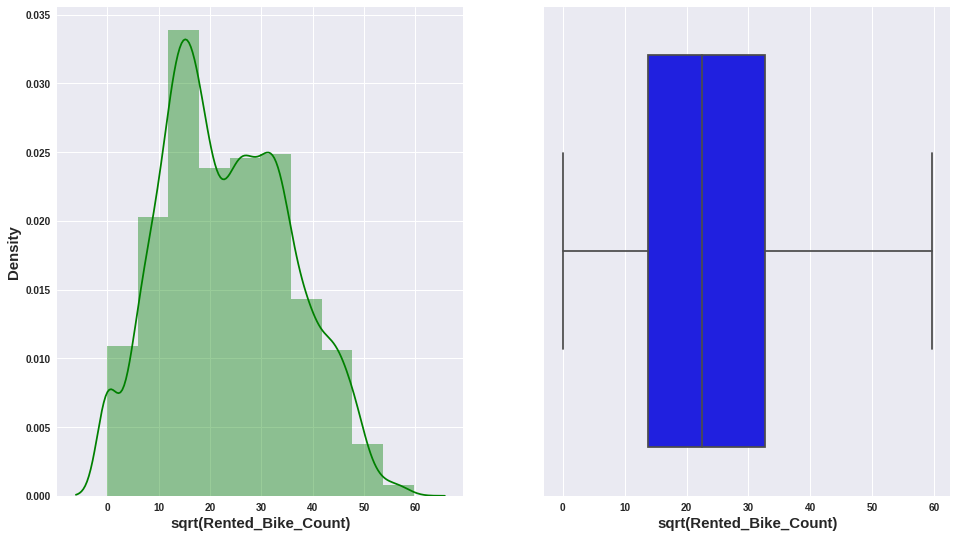

<Figure size 576x396 with 0 Axes>

In [27]:
# log tranformation (adding 1 to bike count to avoid log(0) error)
f, axes = plt.subplots(1, 2,figsize=(16,9))
df['log(Rented_Bike_Count)'] = np.log10(df['Rented_Bike_Count']+1)
fig = plt.figure()
sns.distplot(df['log(Rented_Bike_Count)'], bins = 10 ,color='g',ax=axes[0])
sns.boxplot(df['log(Rented_Bike_Count)'],color='b',ax=axes[1])

#square_root transformation
f, axes = plt.subplots(1, 2,figsize=(16,9))
df['sqrt(Rented_Bike_Count)'] = np.sqrt(df['Rented_Bike_Count'])
fig = plt.figure()
sns.distplot(df['sqrt(Rented_Bike_Count)'], bins = 10 ,color='g',ax=axes[0])
sns.boxplot(df['sqrt(Rented_Bike_Count)'],color='b',ax=axes[1])


plt.show()

In [23]:
print(f"Skewness of Target Variable : {df['Rented_Bike_Count'].skew():.2f}")
#print(f"Skewness of Logarithm of Target Variable : {df['log(Rented_Bike_Count)'].skew():.2f}")
print(f"Skewness of Square root of Target Variable : {df['sqrt(Rented_Bike_Count)'].skew():.2f}")

Skewness of Target Variable : 1.15
Skewness of Square root of Target Variable : 0.24


Here, we could see that the target variable is balanced better, after applying square root transformation and the skewness is greatly reduced.

In [49]:
df.drop(['log(Rented_Bike_Count)','sqrt(Rented_Bike_Count)'],axis=1,inplace=True)

#### ***Linear models without hyperparameter tuning:***

In [201]:
mean_abs_error = []
root_mean_sq_error=[]
root_mean_sq_log_error=[]
train_accuracy_score =[]
test_accuracy_score =[]
r2_list=[]
adj_r2_list=[]

# Define X-variable(Independent Variables) and Y-Variable(Dependent Variable)
X=df.drop('Rented_Bike_Count',axis=1)
y=np.sqrt(df['Rented_Bike_Count'])
# Split data into train test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#scaling the features
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
# Checking shape
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of X_test : {X_test.shape}')
print(f'Shape of y_test : {y_test.shape}')

#instantiating the model
lr = LinearRegression()
l1 = Lasso()
l2 = Ridge()
e  = ElasticNet()

linear_models = [lr,l1,l2,e]
for i in linear_models:
  print('\n')
  print('*'*20,i,'*'*20) 
  i.fit(X_train,y_train)
  y_pred = i.predict(X_test)
  mae = mean_absolute_error(y_test**2,y_pred**2)
  print("MAE :" , np.round(mae,2))
  mse = mean_squared_error(y_test**2,y_pred**2)
  rmse = np.sqrt(mse)
  print("RMSE :" , np.round(rmse,2))
  rmsle= mean_squared_log_error(y_test**2,y_pred**2,squared=False)
  print("RMSLE :" , np.round(rmsle,2))
  r2 = r2_score(y_test**2,y_pred**2)
  print("R2 :" , np.round(r2,2))
  adj_r2 =1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted_R2 :" , np.round(adj_r2,2))
  train_accuracy=i.score(X_train,y_train)
  print("Train accuracy:" , np.round(train_accuracy,2))
  test_accuracy=i.score(X_test,y_test)
  print("Test accuracy:" , np.round(test_accuracy,2))


  train_accuracy_score.append(np.round(train_accuracy,2))
  test_accuracy_score.append(np.round(test_accuracy,2))
  mean_abs_error.append(np.round(mae,2))
  root_mean_sq_error.append(np.round(rmse,2))
  root_mean_sq_log_error.append(np.round(rmsle,2))
  r2_list.append(np.round(r2,2))
  adj_r2_list.append(np.round(adj_r2,2))


Shape of X_train : (6570, 48)
Shape of y_train : (6570,)
Shape of X_test : (2190, 48)
Shape of y_test : (2190,)


******************** LinearRegression() ********************
MAE : 229.34
RMSE : 335.87
RMSLE : 0.99
R2 : 0.73
Adjusted_R2 : 0.72
Train accuracy: 0.76
Test accuracy: 0.78


******************** Lasso() ********************
MAE : 310.4
RMSE : 457.02
RMSLE : 1.0
R2 : 0.5
Adjusted_R2 : 0.49
Train accuracy: 0.62
Test accuracy: 0.63


******************** Ridge() ********************
MAE : 229.35
RMSE : 335.89
RMSLE : 0.99
R2 : 0.73
Adjusted_R2 : 0.72
Train accuracy: 0.76
Test accuracy: 0.78


******************** ElasticNet() ********************
MAE : 311.28
RMSE : 455.33
RMSLE : 1.13
R2 : 0.5
Adjusted_R2 : 0.49
Train accuracy: 0.61
Test accuracy: 0.62


#### ***Defining Function to train the models :***

In [146]:
# creating a list so that all models evalution scores will be appended to the corresponding list after hyperarameter tuning
mean_absolute_error_tuned = []
root_mean_sq_error_tuned=[]
root_mean_sq_log_error_tuned=[]
Train_accuracy_score_tuned =[]
Test_accuracy_score_tuned =[]
r2_list_tuned=[]
adjusted_r2_list_tuned=[]

# creating a function for fit, predict and evaluting the models and append all evalution score in list 
def model_train(model,X_train,X_test,Y_train,Y_test, linear = False):
  '''
    train the model and gives mae, mse,rmse,r2 and adjusted r2 scores of the model 
  '''
  #training the model
  model.fit(X_train,Y_train)
  # Accuracy Score
  train_accuracy  = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5).mean()
  test_accuracy  = cross_val_score(estimator = model, X = X_test, y = y_test, cv = 5).mean()
  print('*'*30, 'Cross validation Accuracy score', '*'*30)
  print("Train Accuracy score  :", np.round(train_accuracy,2))
  print("Test Accuracy score  :", np.round(test_accuracy,2))

  print('\n')

  try:
      # finding the best parameters of the model if any 
    print('*'*20, 'Best Parameters & Best Score', '*'*20)
    print(f"The best parameter that was found out is :{model.best_params_} \n where model's best score is:  {model.best_score_} \n")
  except:
    print('None')
    
    

  #predicting the Test set and evaluting the models 
  print('\n')
  print('*'*20, 'Evalution Metrics', '*'*20)

  if linear == True:
    Y_pred = model.predict(X_test)

    #squaring the target variable test and prediction values as we took y as square root of target variable in modeling.
    #finding mean_absolute_error
    MAE  = mean_absolute_error(Y_test**2,Y_pred**2)
    print("MAE :" , np.round(MAE,2))

    #finding root mean squared error
    MSE  = mean_squared_error(Y_test**2,Y_pred**2)
    RMSE = np.sqrt(MSE)
    print("RMSE :" ,np.round(RMSE,2))

    #finding mean_squared_log_error
    RMSLE  = mean_squared_log_error(Y_test**2,Y_pred**2,squared=False)
    print("RMSLE :" ,np.round(RMSLE,2))

    #finding the r2 score
    '''
    R2 assumes that every single variable explains the variation in the dependent variable
    '''
    r2 = r2_score(Y_test**2,Y_pred**2)
    print("R2 :" ,np.round(r2,2))

    #finding the adjusted r2 score
    '''
    The adjusted R2 gives the percentage of variation explained by 
    only the independent variables that actually affect the dependent variable.
    '''
    adj_r2=1-(1-r2_score(Y_test**2,Y_pred**2))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("Adjusted R2 : ",np.round(adj_r2,2),'\n')
  
  else:
    # for tree base models
    Y_pred = abs(model.predict(X_test))

    #finding mean_absolute_error
    MAE  = mean_absolute_error(Y_test,Y_pred)
    print("MAE :" , np.round(MAE,2))

   #finding root mean squared error
    MSE  = mean_squared_error(Y_test,Y_pred)
    RMSE = np.sqrt(MSE)
    print("RMSE :" ,np.round(RMSE,2))

    #finding mean_squared_log_error
    RMSLE  = mean_squared_log_error(Y_test,Y_pred,squared=False)
    print("RMSLE :" ,np.round(RMSLE,2))

    #finding the r2 score
    
    r2 = r2_score(Y_test,Y_pred)
    print("R2 :" ,np.round(r2,2))
    #finding the adjusted r2 score
    adj_r2=1-(1-r2_score(Y_test,Y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print("Adjusted R2 : ",np.round(adj_r2,2),'\n')

    

    #Top 10 feature importance graph
    try:
      best = model.best_estimator_
      features = new_X.columns
      importances = best.feature_importances_[0:10]
      indices = np.argsort(importances)
      plt.figure(figsize=(10,15))
      plt.title('Feature Importance')
      plt.barh(range(len(indices)), importances[indices], color='blue',edgecolor='pink' ,align='center')
      plt.yticks(range(len(indices)), [features[i] for i in indices])
      plt.xlabel('Relative Importance')
      plt.show()
    
    except:
      pass
  # Here we appending the parameters for all models 
  mean_absolute_error_tuned.append(np.round(MAE,2))
  root_mean_sq_log_error_tuned.append(np.round(RMSLE,2))
  root_mean_sq_error_tuned.append(np.round(RMSE,2))
  Train_accuracy_score_tuned.append(np.round(train_accuracy,2))
  Test_accuracy_score_tuned.append(np.round(test_accuracy,2))
  r2_list_tuned.append(np.round(r2,2))
  adjusted_r2_list_tuned.append(np.round(adj_r2,2))
  
  print('*'*20, 'ploting the graph of actual and predicted only with 100 observation', '*'*20)

  # ploting the graph of Actual and predicted only with 100 observation for better visualisation which model have these parameters and else we just pass them
  try:
    # ploting the line graph of actual and predicted values  
    plt.figure(figsize=(15,7))
    plt.plot((Y_pred)[:100])
    plt.plot((np.array(Y_test)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.show()
  except:
    pass

#### ***Linear Models with Hyperparameter tuning :***

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.67
Test Accuracy score  : 0.66


******************** Best Parameters & Best Score ********************
None


******************** Evalution Metrics ********************
MAE : 514456.12
RMSE : 965159.38
RMSLE : 2.86
R2 : 0.57
Adjusted R2 :  0.56 

******************** ploting the graph of actual and predicted only with 100 observation ********************


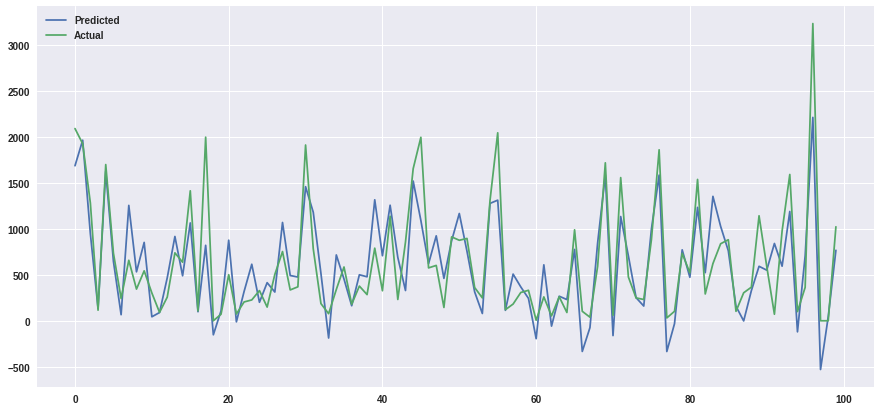

In [147]:
LR=LinearRegression()
model_train(LR,X_train,X_test,y_train,y_test,linear=True)


######**Lasso Regression**

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.67
Test Accuracy score  : 0.66


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 0.1} 
 where model's best score is:  0.6747097117307337 



******************** Evalution Metrics ********************
MAE : 515293.86
RMSE : 967077.26
RMSLE : 2.86
R2 : 0.56
Adjusted R2 :  0.55 

******************** ploting the graph of actual and predicted only with 100 observation ********************


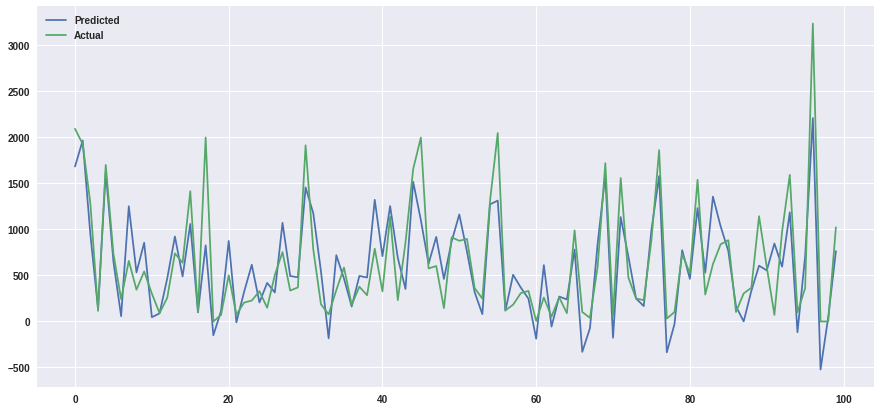

In [148]:
# Using Grid Search CV for Hyperparameter tuning of Lasso Regression model
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]} #lasso parameters 
L1 = GridSearchCV(Lasso(), parameters, cv=5) #using gridsearchcv and cross validation on the model
# fit and evaluate model 
model_train(L1,X_train,X_test,y_train,y_test,linear=True)

######**Ridge Regression**

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.67
Test Accuracy score  : 0.66


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 1} 
 where model's best score is:  0.6750595271231609 



******************** Evalution Metrics ********************
MAE : 515105.35
RMSE : 967046.54
RMSLE : 2.86
R2 : 0.56
Adjusted R2 :  0.55 

******************** ploting the graph of actual and predicted only with 100 observation ********************


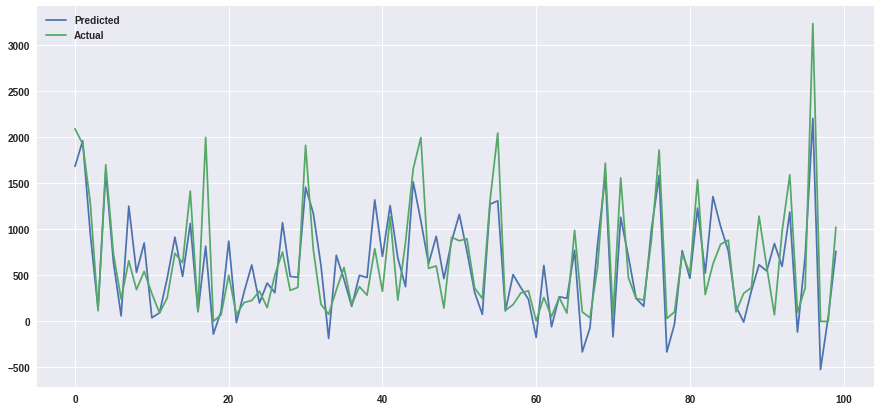

In [149]:
# Using Grid Search CV for Hyperparameter tuning for Lasso Regression
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100,0.5,1.5,1.6,1.7,1.8,1.9]} # giving parameters 
L2 = GridSearchCV(Ridge(), parameters, cv=5) #using gridsearchcv and cross validate the model
# fit and evaluate model with score_matrix function
model_train(L2,X_train,X_test,y_train,y_test,linear=True)

######**Elastic Regression**

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.67
Test Accuracy score  : 0.66


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'alpha': 0.001, 'l1_ratio': 0.9} 
 where model's best score is:  0.6749688322737172 



******************** Evalution Metrics ********************
MAE : 514872.52
RMSE : 966394.01
RMSLE : 2.86
R2 : 0.56
Adjusted R2 :  0.55 

******************** ploting the graph of actual and predicted only with 100 observation ********************


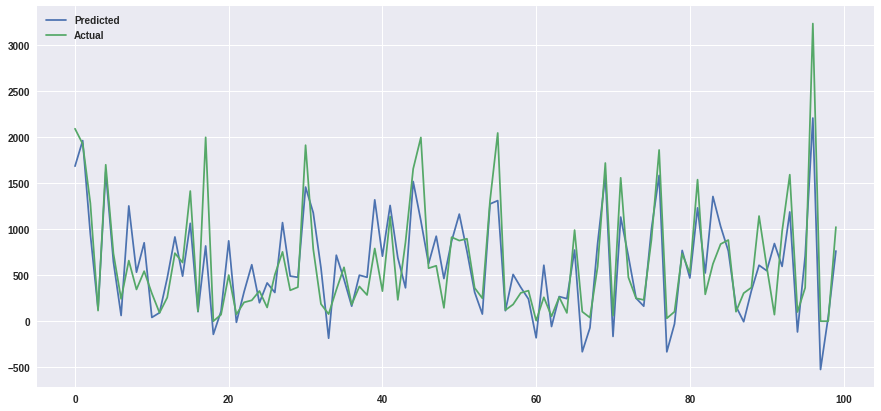

In [150]:
 # Using Grid Search CV for Hyperparameter tuning for Lasso Regression
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100,0.5,1.5,1.6,1.7,1.8,1.9],'l1_ratio':[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]} # giving parameters 
E = GridSearchCV(ElasticNet(), parameters, cv=5) #using gridsearchcv and cross validate the model
# fit and evaluate model with score_matrix function
model_train(E,X_train,X_test,y_train,y_test,linear=True)

######**Polynomial Regression**

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.67
Test Accuracy score  : 0.66


******************** Best Parameters & Best Score ********************
None


******************** Evalution Metrics ********************
MAE : 514456.12
RMSE : 965159.38
RMSLE : 2.86
R2 : 0.57
Adjusted R2 :  0.56 

******************** ploting the graph of actual and predicted only with 100 observation ********************


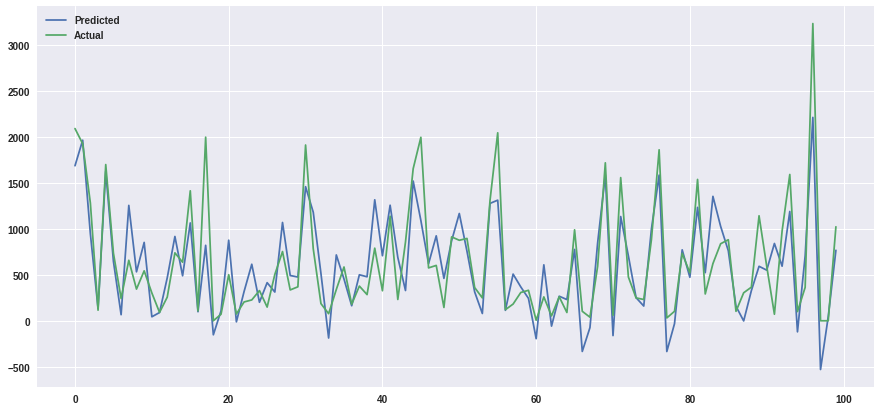

In [151]:
from sklearn.preprocessing import PolynomialFeatures
P = PolynomialFeatures(degree=2,include_bias = False) #creating variables with degree 4
P_X_train = P.fit_transform(X_train) # fit the train set
P_X_test = P.transform(X_test) #transform the test set
# fit and evaluate model with score_matrix function
model_train(lr,X_train,X_test,y_train,y_test,linear=True)

#### ***Data Splitting for Tree based Models:***
As Desicion trees make no assumptions on relationships between features, so we can use all the independent features because multi collinearity won't affect the model.Also, we are not transforming the target variable here, as it's distribution won't have impact on model accuracy.

In [202]:
# Creating DataFrame for tree base models
t_df = pd.get_dummies(Bikes_df,columns=['Seasons','Holiday','Functioning_Day','Month','Hour','Weekend'],drop_first=True)
t_df.drop(['Day'],inplace=True,axis=1)
# Split data in X and Y
new_X = t_df.drop(columns='Rented_Bike_Count')
new_y = t_df['Rented_Bike_Count']
# Train test split our data
X_train,X_test,y_train,y_test = train_test_split(new_X,new_y, test_size=0.25)
#Feature scaling
scaler = MinMaxScaler()
X_train  = scaler.fit_transform(X_train) #fitting the X_train
X_test   = scaler.transform(X_test) # transform test set

##### ***Tree Based Models without Hyper Parameter tuning :***

In [203]:
#instantiating the models
dt= DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor(objective ='reg:squarederror')

tree_models = [dt,rf,xgb]
for i in tree_models:
  print('\n')
  print('*'*20,i,'*'*20) 
  i.fit(X_train,y_train)
  y_pred = i.predict(X_test)
  mae = mean_absolute_error(y_test,y_pred)
  print("MAE :" , np.round(mae,2))
  mse = mean_squared_error(y_test,y_pred)
  rmse = np.sqrt(mse)
  print("RMSE :" , np.round(rmse,2))
  rmsle= mean_squared_log_error(y_test**2,y_pred**2,squared=False)
  print("RMSLE :" , np.round(rmsle,2))
  r2 = r2_score(y_test,y_pred)
  print("R2 :" , np.round(r2,2))
  adj_r2 =1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted_R2 :" , np.round(adj_r2,2))
  train_accuracy=i.score(X_train,y_train)
  print("Train_Accuracy :",np.round(train_accuracy,2))
  test_accuracy=i.score(X_test,y_test)
  print("Test_Accuracy :",np.round(test_accuracy,2))
  train_accuracy_score.append(np.round(train_accuracy,2))
  test_accuracy_score.append(np.round(test_accuracy,2))
  mean_abs_error.append(np.round(mae,2))
  root_mean_sq_log_error.append(np.round(rmsle,2))
  root_mean_sq_error.append(np.round(rmse,2))
  r2_list.append(np.round(r2,2))
  adj_r2_list.append(np.round(adj_r2,2))




******************** DecisionTreeRegressor() ********************
MAE : 174.86
RMSE : 304.19
RMSLE : 1.49
R2 : 0.78
Adjusted_R2 : 0.78
Train_Accuracy : 1.0
Test_Accuracy : 0.78


******************** RandomForestRegressor() ********************
MAE : 139.23
RMSE : 228.99
RMSLE : 1.35
R2 : 0.88
Adjusted_R2 : 0.87
Train_Accuracy : 0.98
Test_Accuracy : 0.88


******************** XGBRegressor(objective='reg:squarederror') ********************
MAE : 194.86
RMSE : 280.23
RMSLE : 2.14
R2 : 0.81
Adjusted_R2 : 0.81
Train_Accuracy : 0.83
Test_Accuracy : 0.81


#### ***Tree based models with Hyper Parameter tuning :***

##### ***Decision Tree Regression :***

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.79
Test Accuracy score  : 0.77


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 25, 'splitter': 'best'} 
 where model's best score is:  0.790359319780511 



******************** Evalution Metrics ********************
MAE : 168.84
RMSE : 267.2
RMSLE : 0.6
R2 : 0.82
Adjusted R2 :  0.82 



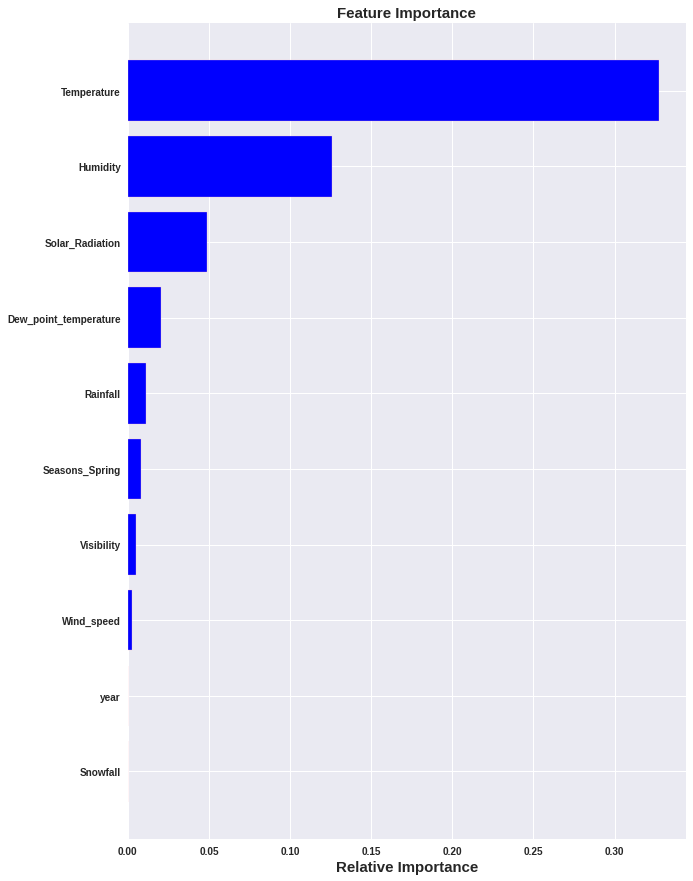

******************** ploting the graph of actual and predicted only with 100 observation ********************


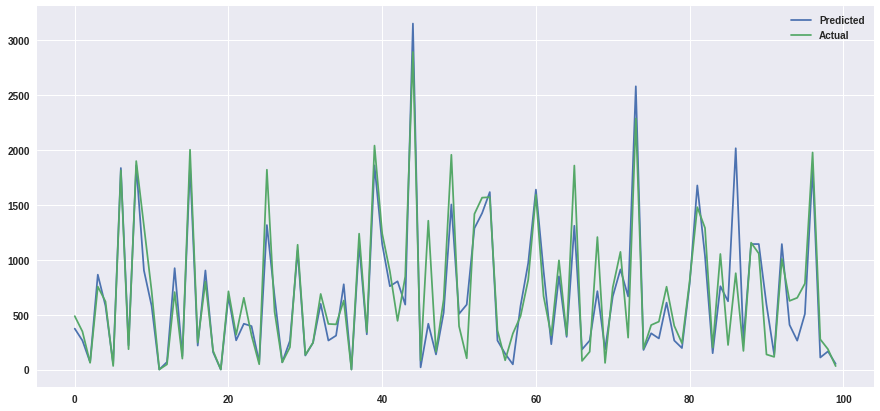

In [154]:
# Parameters for Decission Tree model
param_grid = {'splitter':['best','random'],
              'max_depth' : [5,15,25],
              'max_features':['auto','log2','sqrt'],
              'min_samples_leaf':[5,7,10],
              'min_samples_split': [15,25,30]}
# Using Grid Search 
DT= GridSearchCV(DecisionTreeRegressor(),param_grid=param_grid,cv=5)
# fit and evaluate model 
model_train(DT,X_train,X_test,y_train,y_test)

[Text(0.5089285714285714, 0.9, 'Temperature <= 0.519\nsquared_error = 419663.656\nsamples = 6570\nvalue = 704.051'),
 Text(0.2857142857142857, 0.7, 'Seasons_Winter <= 0.5\nsquared_error = 122168.122\nsamples = 3048\nvalue = 362.008'),
 Text(0.14285714285714285, 0.5, 'Solar_Radiation <= 0.001\nsquared_error = 190462.194\nsamples = 1416\nvalue = 520.427'),
 Text(0.07142857142857142, 0.3, 'Humidity <= 0.638\nsquared_error = 125067.028\nsamples = 872\nvalue = 390.969'),
 Text(0.03571428571428571, 0.1, '\n  (...)  \n'),
 Text(0.10714285714285714, 0.1, '\n  (...)  \n'),
 Text(0.21428571428571427, 0.3, 'Hour_8 <= 0.5\nsquared_error = 225360.39\nsamples = 544\nvalue = 727.941'),
 Text(0.17857142857142858, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.1, '\n  (...)  \n'),
 Text(0.42857142857142855, 0.5, 'Solar_Radiation <= 0.001\nsquared_error = 22244.64\nsamples = 1632\nvalue = 224.555'),
 Text(0.35714285714285715, 0.3, 'Hour_18 <= 0.5\nsquared_error = 19017.352\nsamples = 962\nvalue = 178.007'),
 Text

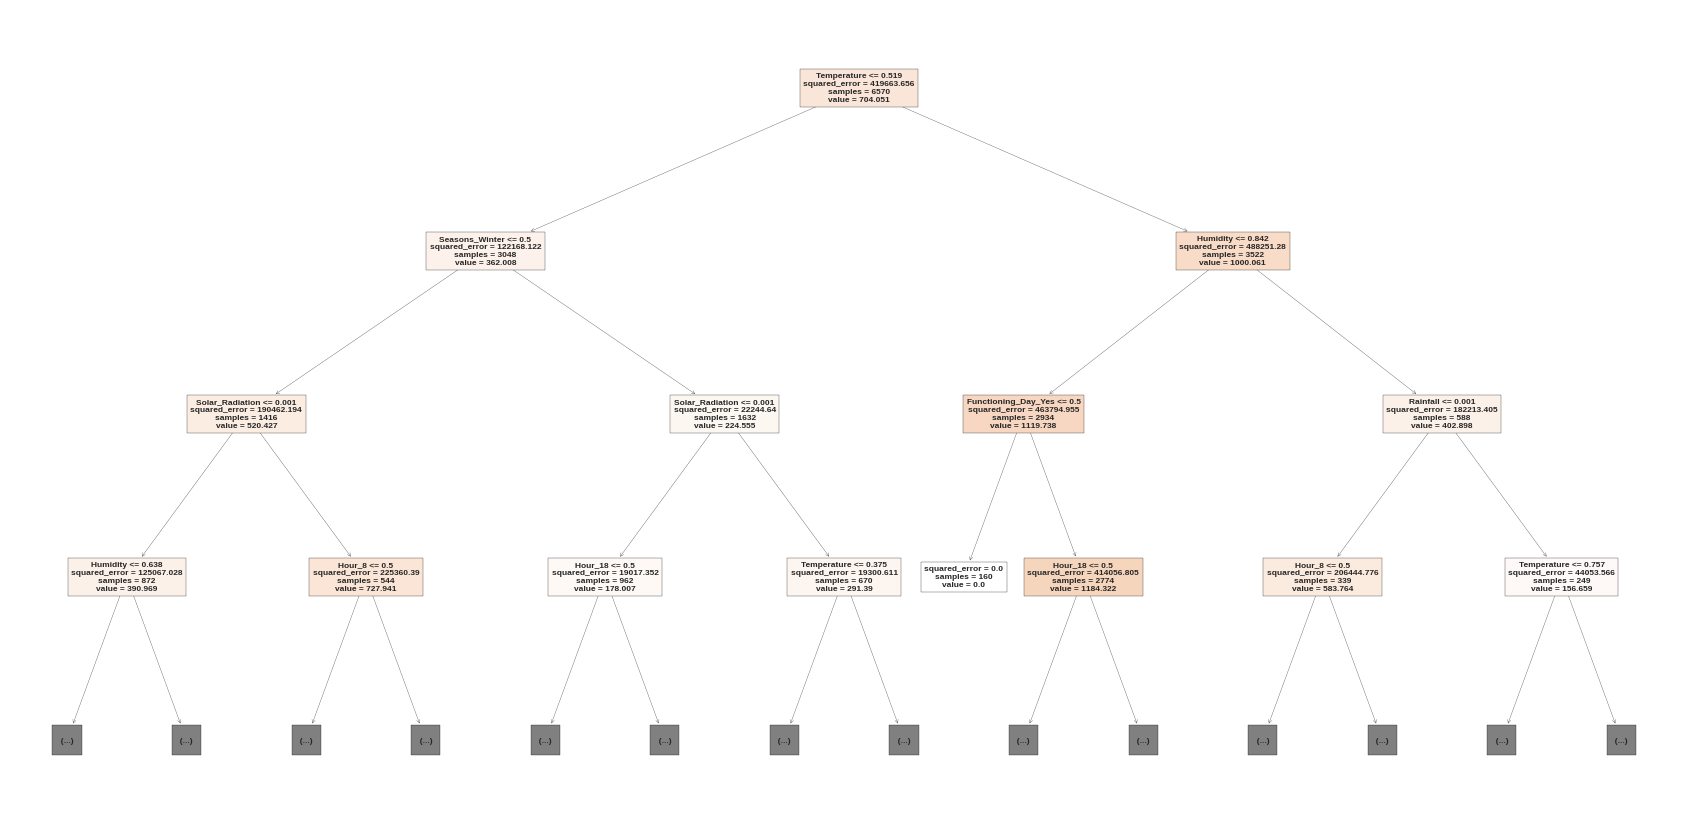

In [155]:
plt.figure(figsize=(30,15))
plot_tree(dt, feature_names=new_X.columns, max_depth=3, filled=True)

##### ***Random Forest Regressor :***

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.84
Test Accuracy score  : 0.81


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 25, 'n_estimators': 150} 
 where model's best score is:  0.8399310050176112 



******************** Evalution Metrics ********************
MAE : 151.28
RMSE : 232.33
RMSLE : 0.66
R2 : 0.87
Adjusted R2 :  0.86 



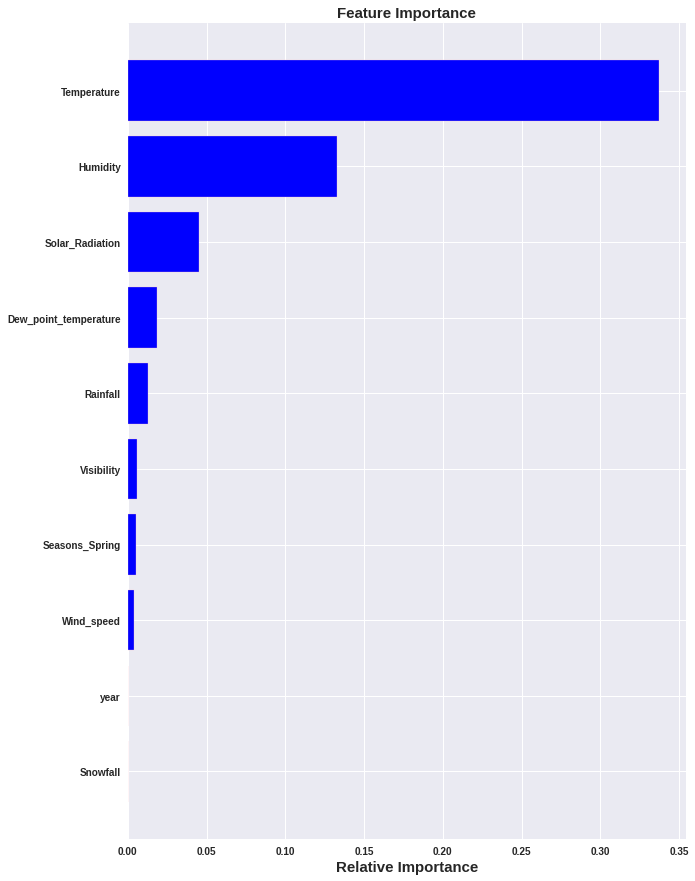

******************** ploting the graph of actual and predicted only with 100 observation ********************


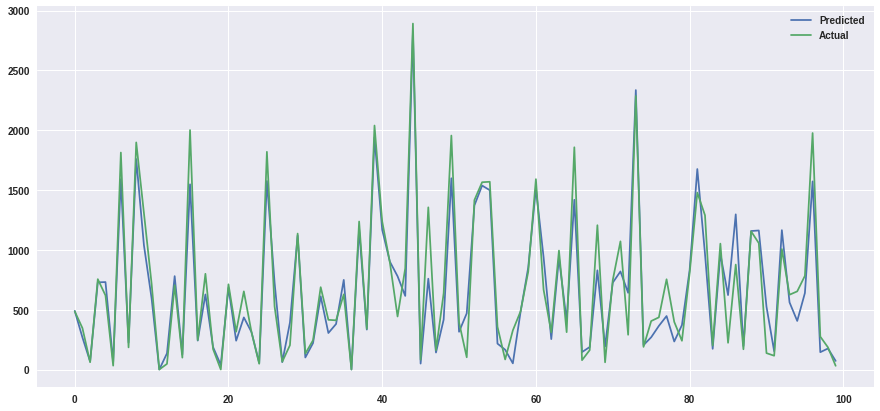

In [156]:
param_grid={'n_estimators':[50,150,250],'max_depth':[5,15,20],'max_features':['auto','log2','sqrt'],'min_samples_split': [10,25,30],'min_samples_leaf':[2,4,8]}
# Using Grid SearchCV 
RF= GridSearchCV(RandomForestRegressor(),param_grid=param_grid,cv=5)
# fit and evaluate model 
model_train(RF,X_train,X_test,y_train,y_test)

##### ***Extreme Gradient Booster Regressor*** :

****************************** Cross validation Accuracy score ******************************
Train Accuracy score  : 0.89
Test Accuracy score  : 0.86


******************** Best Parameters & Best Score ********************
The best parameter that was found out is :{'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 150, 'subsample': 0.5} 
 where model's best score is:  0.8874590378752851 



******************** Evalution Metrics ********************
MAE : 136.26
RMSE : 211.12
RMSLE : 0.97
R2 : 0.89
Adjusted R2 :  0.89 



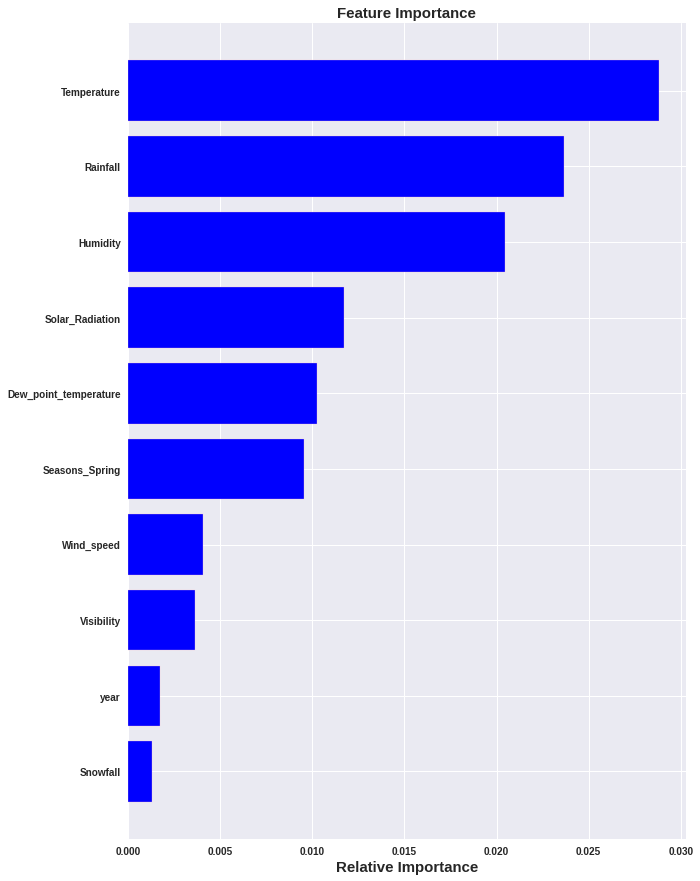

******************** ploting the graph of actual and predicted only with 100 observation ********************


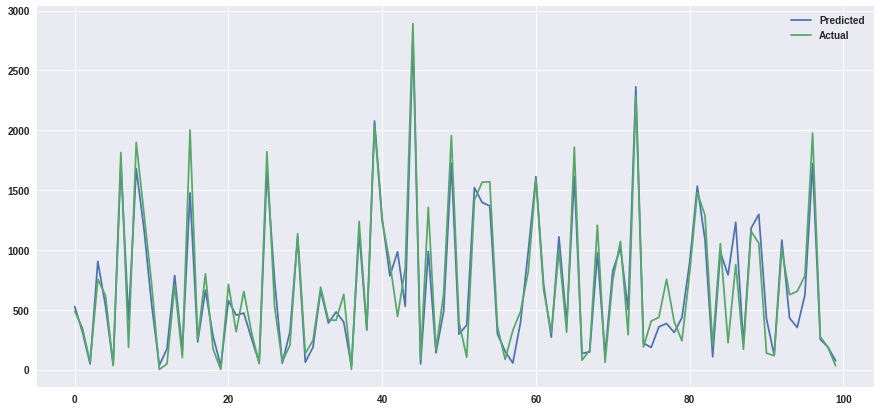

In [157]:
param_grid ={
          'subsample': [0.3,0.5,0.7,0.9], 
          'n_estimators':[50,150,250],  
          'max_depth':[2,6,10,15],
          'min_samples_leaf':[4,6,10], 
          }

XGB= GridSearchCV(XGBRegressor(verbosity = 0),param_grid=param_grid,cv=5)
# fit and evaluate model 
model_train(XGB,X_train,X_test,y_train,y_test)


#### ***Evaluation metrics Comparision :***

#####  ***Without Hyper parameter tuning:***

In [204]:
# creating a Data frame of model scores without hyperparameter tuning
model_names = ['Linear Regression','Ridge','Lasso','Elastic','Decision_Tree','Random_Forest','xg_boost']
#creating dictionary to store all the metrices 
all_metrics={'Train_Accuracy_score':train_accuracy_score,'Test_Accuracy_score':test_accuracy_score,'RMSLE':root_mean_sq_log_error,'Adjusted_R2':adj_r2_list}
#converting dictionary to dataframe for simple visualization 
metrics=pd.DataFrame.from_dict(all_metrics,orient='index',columns=model_names)
# Adjusted R2 score is set in descending order 
metrics = metrics.transpose().sort_values("Adjusted_R2",ascending=False).reset_index().rename(columns={'index':'model'})
metrics

,model,Train_Accuracy_score,Test_Accuracy_score,RMSLE,Adjusted_R2
0,Random_Forest,0.98,0.88,1.35,0.87
1,xg_boost,0.83,0.81,2.14,0.81
2,Decision_Tree,1.00,0.78,1.49,0.78
3,Linear Regression,0.76,0.78,0.99,0.72
4,Lasso,0.76,0.78,0.99,0.72
5,Ridge,0.62,0.63,1.00,0.49
6,Elastic,0.61,0.62,1.13,0.49


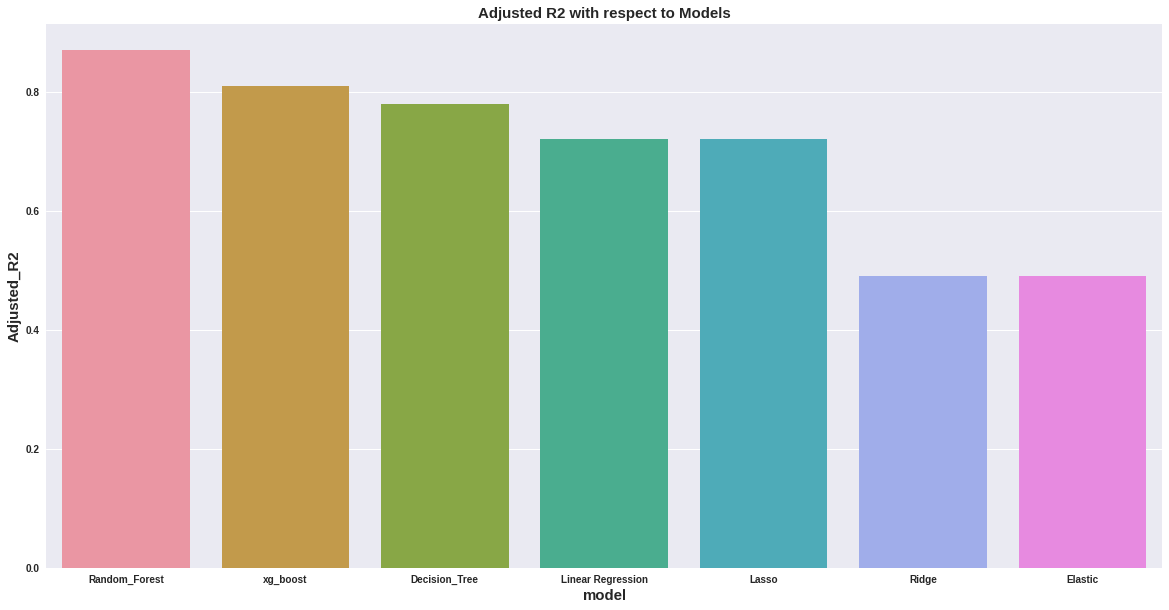

In [205]:
plt.figure(figsize=(20,10))
sns.barplot(y='Adjusted_R2', x = 'model', data=metrics)
plt.title("Adjusted R2 with respect to Models",fontsize=15)
plt.show()

#####  ***With Hyper parameter tuning:***

In [161]:
# creating a Data frame of model scores without hyperparameter tuning
model_names = ['Linear Regression','Ridge','Lasso','Elastic','Polynomial','Decision_Tree','Random_Forest','xg_boost']
#creating dictionary to store all the metrices 
all_metrics_tuned={'Train_Accuracy_score':Train_accuracy_score_tuned,'Test_Accuracy_score':Test_accuracy_score_tuned,'RMSLE':root_mean_sq_log_error_tuned,'Adjusted_R2':adjusted_r2_list_tuned}
#converting dictionary to dataframe for simple visualization 
metrics_tuned=pd.DataFrame.from_dict(all_metrics_tuned,orient='index',columns=model_names)
# Adjusted R2 score is set in descending order 
metrics_tuned = metrics_tuned.transpose().sort_values("Adjusted_R2",ascending=False).reset_index().rename(columns={'index':'model'})
metrics_tuned

,model,Train_Accuracy_score,Test_Accuracy_score,RMSLE,Adjusted_R2
0,xg_boost,0.89,0.86,0.97,0.89
1,Random_Forest,0.84,0.81,0.66,0.86
2,Decision_Tree,0.79,0.77,0.60,0.82
3,Linear Regression,0.67,0.66,2.86,0.56
4,Polynomial,0.67,0.66,2.86,0.56
5,Ridge,0.67,0.66,2.86,0.55
6,Lasso,0.67,0.66,2.86,0.55
7,Elastic,0.67,0.66,2.86,0.55


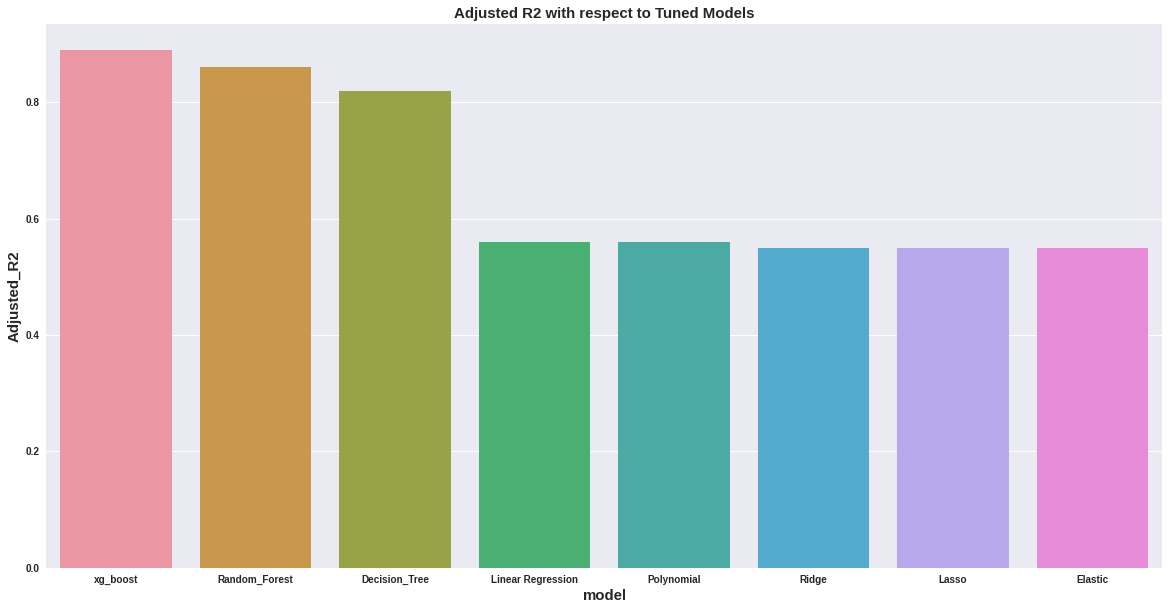

In [160]:
plt.figure(figsize=(20,10))
sns.barplot(y='Adjusted_R2', x = 'model', data=metrics_tuned)
plt.title("Adjusted R2 with respect to Tuned Models",fontsize=15)
plt.show()

#### ***Creating Pickle File to save model***

In [162]:
# Save the Model to file in the current working directory
Pkl_Filename = "Pickle_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(XGB, file)

#### ***Reusing Model from Pickel File :***

In [163]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_XGB_Model = pickle.load(file)
Pickled_XGB_Model

# Use the Reloaded Model to Calculate the accuracy score and predict target values
# Calculate the Score 
score = Pickled_XGB_Model.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

# Predict the Labels using the reloaded Model
Ypredict = Pickled_XGB_Model.predict(X_test)  

Test score: 88.98 %


### **Reinforcement Learnning Approach :**

##### ***Environment*** :
    The environment module is a bike station object that does the following functions:
    1.generates simulated and real bike stock data
    2.delivers feedback to the RL agent in the form of bike inventory, incentives/penalties,episode termination status 
    3.updates the bike stock in response to the action taken by the RL agent
    4.resets the environment for a new training session.

In [190]:

import numpy as np
import pandas as pd
import json

class bikestation():
    
    def __init__(self, mode):    
        print("Creating A Bike Station Environment!!!")
        self.mode = mode
        self.seed = np.random.random_integers(0, 10)
        self.num_hours = 23
        self.current_hour = 0
        self.bike_count_sim = self.generate_count(mode)
         # to be reset to original environment after  every episode
        self.bike_count = self.bike_count_sim.copy()
        self.old_count = self.bike_count[0]
        self.new_count = 0
        self.done = False
        self.reward = 0
        self.bike_moved = 0
        self.actions = [-10,-3,-1, 0]
        self.n_actions = len(self.actions)
        #features of the observation: hour, old count, new count
        #self.n_features = 1
        self.game_over = False

    def generate_count(self, mode):
        # generate a list of 24 hourly bike count based on mode
        # mode: linear which is addition of 3 bikes continuously , random is addition of 3 bikes with a random integer between -5 to 5.
        #initialising the bike stock to be 30 
        bike_count = [20]
        if mode == "linear":
            for i in range(1, 24):
                bike_count.append(bike_count[i-1]+3)
        if mode == "random":
            for i in range(1, 24):
                bike_count.append(bike_count[i-1] + 3 + np.random.random_integers(-5, 5))
        return bike_count

    def feedback(self, action):
        # share back count, reward ,and termination status to agent
  
        if action != 0:
            #if there is any rebalancing happening 
            self.update_count(action)
            self.reward = -0.5*np.abs(action)
            #if the count is greater than 50 at any hour
        if self.bike_count[self.current_hour] > 50:
            self.reward = -30
            #if count is less than 20 at any moment
        if self.bike_count[self.current_hour] < 20:
            self.reward = -30
        if self.current_hour == 23:
            #If count is between 0 to 50  at last hour
            if (self.bike_count[self.current_hour] <= 50)&(self.bike_count[self.current_hour] > 20):
                self.reward = 20
            else: 
                self.reward = -20
            self.done = True
            self.game_over = True
        # update to next hour
        if self.current_hour != 23:
            self.update_hour()
            self.old_count = self.bike_count[self.current_hour - 1]
            self.new_count = self.bike_count[self.current_hour]
        return self.current_hour, self.old_count, self.new_count, self.reward, self.done, self.game_over
    
    def get_old_count(self):
        return self.old_count
    
    def update_count(self, num_bike):
        # update bike count based on RL Agent action 
        if self.current_hour != 23:
            for hour in range(self.current_hour+1, len(self.bike_count)):
                self.bike_count[hour] += num_bike
            self.bike_moved = num_bike
        else:
            pass
        return
    
    def update_hour(self):
        # update current_hour 
        self.current_hour += 1
        return
    
    def reset(self):
        self.num_hours = 23
        self.current_hour = 0
        self.bike_count = self.bike_count_sim.copy()
        self.done = False
        self.reward = 0
        self.bike_moved = 0
        self.old_count = self.bike_count[0]
        self.new_count = 0
        
    def current_count(self):
        return self.bike_count[self.current_hour]
    
    def get_sim_count(self):
        return self.bike_count 

##### ***`Agent :`***

>  Agent is analagous to Bike station Operator.The agent's action is the number of bikes it can move per hour. At any given hour, the agent has the option of moving 0, 1, 3, or 10 bikes. The reward and punishment structure are as follows:

*   -30 if the hourly bike stock falls outside the range [20, 50].
*   +20 if bike stock is in the range [20, 50] at 23 hours; otherwise, -20
*   -0.5  times the number of bikes eliminated every hour.










In [191]:
import numpy as np
import pandas as pd

class agent():

    def __init__(self,epsilon, lr, gamma, current_count):
        print("Creating an Agent !!!")
        #Defining actions which is count of bikes that can be moved at a certain hour
        self.actions = [-10,-3,-1, 0]
        self.reward = 0
        self.lr = lr
        self.epsilon=epsilon
        self.gamma = gamma
        self.current_count = current_count
        # performance metric
        self.q_table = pd.DataFrame(columns = self.actions, dtype = np.float64)
        self.hourly_action_history = []
        self.hourly_count_history = []
       
    def choose_action(self, s):
        '''
        This funciton choose an action based on Q Table. It also does 
        validation to ensure count will not be negative after moving bikes.
        Input: 
            - s: current bike count
        
        Output:
            - action: number of bikes to move
        '''
        self.check_state_exist(s)
        self.current_count = s
        # find valid action based on current count 
        valid_state_action = self.find_valid_action(self.q_table.loc[s, :])
        # valid_state_action = self.q_table.loc[s, :]
        if np.random.uniform() < self.epsilon:
            try:
                # find the action with the highest expected reward
                valid_state_action = valid_state_action.reindex(np.random.permutation(valid_state_action.index))
                action = valid_state_action.idxmax()
            except:
                # if action list is null, default to 0
                action = 0
        else:
            # randomly choose an action
            try:
                action = np.random.choice(valid_state_action.index)
            except:
                action = 0
        self.hourly_action_history.append(action)
        self.hourly_count_history.append(s)
        return action

    def learn(self, s, a, r, s_, g):
        '''
        This function updates Q tables after each interaction with the
        environment.
        Input: 
            - s: current bike count
            - a: current action (number of bikes to move)
            - r: reward received from current state
            - s_: new bike count based on bike moved and new count
        Output: None
        '''
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if g == False:
            # Updated Q Target Value if it is not end of day  
            q_target = r + self.gamma * self.q_table.loc[s_, :].max()
        else:
            # Update Q Target Value as Immediate reward if end of day
            q_target = r
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)
        return

    def check_state_exist(self, state):
        # Add a new row with state value as index if not exist
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                        [0]*len(self.actions), 
                        index = self.q_table.columns,
                        name = state
                        )
                )
        return
    
    def find_valid_action(self, state_action):
        '''
        This function check the validity acitons in a given state.
        Input: 
            - state_action: the current state under consideration
        Output:
            - state_action: a pandas Series with only the valid actions that
                            will not cause negative count
        '''
        # remove action that will count to be negative
        for action in self.actions:
            if self.current_count + action < 0:
                state_action.drop(index = action, inplace = True)
        return state_action
        
    
    def print_q_table(self):
        print(self.q_table)

    def get_q_table(self):
        return self.q_table

    def get_hourly_actions(self):
        return self.hourly_action_history
    
    def get_hourly_counts(self):
        return self.hourly_count_history

    def reset_hourly_history(self):
        self.hourly_action_history = []
        self.hourly_count_history = []



In [192]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

class trainer():
    def __init__(self):
        # Session Properties
        self.episodes = []
        self.count_type = ""
        self.logging = False
        self.bike_station = None
        self.operator = None
        self.sim_count = []
        # Performance Metric
        self.success_ratio = 0
        self.rewards = []  # [[r from session 1], [r from session 2] ...]
        self.avg_rewards = [] #[np.mean([r from session 1]), np.mean([r from session 2])...]
        self.final_counts = [] # [[count from session 1], [count from session 2] ...]
        self.episode_action_history = []
        self.episode_count_history = []
        self.session_action_history = []
        self.session_count_history = []
        self.q_tables = []
        self.actions = [-10,-3,-1, 0]
        
    def start(self, episodes, count_type, logging):
        self.episodes = episodes
        self.count_type = count_type
        self.logging = logging
        idx = 0
        for eps in self.episodes:
            # Initiate new evironment and RL agent
            self.bike_station = bikestation(self.count_type)
            self.sim_count.append(self.bike_station.get_sim_count())

            self.operator = agent(epsilon = 0.9, lr = 0.01, gamma = 0.9, current_count = self.bike_station.current_count())
            # Train the RL agent and collect performance stats
            rewards, final_counts = self.train_operator(idx, len(self.episodes), eps, logging = self.logging)
            # Log the results from this training session
            self.rewards.append(rewards)
            self.avg_rewards.append(np.mean(rewards))
            self.final_counts.append(final_counts)
            self.q_tables.append(self.operator.get_q_table())
            self.session_action_history.append(self.episode_action_history)
            self.session_count_history.append(self.episode_count_history)
            self.reset_episode_history()
            # Destroy the environment and agent objects
            self.bike_station = None
            self.operator = None
            idx += 1
        if logging == True:
            self.save_session_results(self.get_timestamp(replace = True))
        return
    
    def train_operator(self, idx, num_sessions, episodes, logging):
        '''
        This function trains an RL agent by interacting with the bike station 
        environment. It also tracks and reports performance stats.
        Input:
            - episodes: a int of episode to be trained in this session (e.g. 500)
        Output:
            - reward_list: a list of reward per episode in this sesison
            - final_counts: a list of final counts per episode in this session
        '''
        print("Start training the Agent !!!")
        rewards = 0
        reward_list = []
        final_counts = []
        step = 0
        for eps in range(episodes):
            self.bike_station.reset()
            while True:
                # Agent picks an action (number of bikes to move)
                # Agent sends the action to bike station environment
                # Agent gets feedback from the environment (e.g. reward of the action, new bike count after the action, etc.)
                # Agent "learn" the feedback by updating its Q-Table (state, action, reward)
                # Repeat until end of day (23 hours)
                # Reset bike station environment to start a new day, repeat all
                action = self.operator.choose_action(self.bike_station.get_old_count())
                current_hour, old_count, new_count, reward, done, game_over = self.bike_station.feedback(action)
                #observation_, reward, done = self.bike_station.feedback(action)
                if done == True:
                    print("{} of {} Session | Episode: {} | Final count: {} |Final Reward: {:.2f}".format(idx, 
                          num_sessions, eps, old_count, rewards))
                    reward_list.append(rewards)
                    final_counts.append(old_count)
                    rewards = 0
                    # Log session action history by episode
                    self.episode_action_history.append(self.operator.get_hourly_actions())
                    self.episode_count_history.append(self.operator.get_hourly_counts())
                    self.operator.reset_hourly_history()               
                    break
                self.operator.learn(old_count, action, reward, new_count, game_over)
                step +=1
                rewards += reward                    
        return reward_list, final_counts
    
    def get_timestamp(self, replace):
        if replace == True:
            return str(datetime.datetime.now()).replace(" ", "").replace(":", "").\
                        replace(".", "").replace("-", "")
        else:
            return str(datetime.datetime.now())
    
    def reset_episode_history(self):
        self.episode_action_history = []
        self.episode_count_history = []
        
    def cal_performance(self):
        successful_counting = []
        print("===== Performance =====")
        for session in range(len(self.final_counts)):
            length = len(self.final_counts[session])
            num_overcount = np.count_nonzero(np.array(self.final_counts[session]) > 50)
            num_undercount = np.count_nonzero(np.array(self.final_counts[session]) <= 20)
            ratio = (length - num_undercount - num_overcount)*100 / length
            print("Session {} | Overcount {} Times | Undercount {} Times | {}% Successful".format(session, num_overcount, 
                  num_undercount, ratio))
            average_reward = round(self.avg_rewards[session], 2)
            print("Average Episode Reward for Session: {}".format(average_reward))
            successful_counting.append(ratio)
        return successful_counting
    
    def save_session_results(self, timestamp):
        '''
        This function logs the following: 
            - overall success ratio of each session
            - Q Table of each session
        '''
        # --- create a session folder ---
        dir_path = "./performance_log/" + timestamp
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        successful_counting = self.cal_performance()
        # --- Write Success Rate to File ---
        fname = dir_path + "/success_rate - " + timestamp + ".txt"
        with open(fname, 'w') as f:
            f.write("Logged at {}".format(self.get_timestamp(replace = False)))
            f.write("\n")
            f.write("This training session ran episodes: {}".format(self.episodes))
            f.write("\n")
            for session in range(len(successful_counting)):
                f.write("Session {} | Episodes: {} | Success Rate: {:.2f}%".format(session, 
                        self.episodes[session], successful_counting[session]))
                f.write("\n")
        # --- Save Q tables --- 
        for session in range(len(self.q_tables)):
            self.q_tables[session].to_csv(dir_path + "/q_table_session_" + \
                        str(session) + timestamp + ".csv")


episode_list = [eps for eps in range(10,40,10)]
mode = input("Linear or Random?: ").lower()
if __name__ == "__main__":
    trainer = trainer()
    trainer.start(episode_list, mode, logging = True)

Linear or Random?: random
Creating A Bike Station Environment!!!
Creating an Agent !!!
Start training the Agent !!!
0 of 3 Session | Episode: 0 | Final count: 9 |Final Reward: -525.00
0 of 3 Session | Episode: 1 | Final count: 20 |Final Reward: -302.50
0 of 3 Session | Episode: 2 | Final count: 18 |Final Reward: -67.00
0 of 3 Session | Episode: 3 | Final count: 33 |Final Reward: -63.00
0 of 3 Session | Episode: 4 | Final count: 24 |Final Reward: -41.00
0 of 3 Session | Episode: 5 | Final count: 34 |Final Reward: -171.00
0 of 3 Session | Episode: 6 | Final count: 27 |Final Reward: -67.00
0 of 3 Session | Episode: 7 | Final count: 22 |Final Reward: -52.00
0 of 3 Session | Episode: 8 | Final count: 0 |Final Reward: -532.00
0 of 3 Session | Episode: 9 | Final count: 35 |Final Reward: -66.50
Creating A Bike Station Environment!!!
Creating an Agent !!!
Start training the Agent !!!
1 of 3 Session | Episode: 0 | Final count: 35 |Final Reward: -447.00
1 of 3 Session | Episode: 1 | Final count: 